### Importing Libraries

In [76]:
import pandas as pd
import plotly.express as px
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.subplots import make_subplots
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn import metrics 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
import mlflow.sklearn
import scipy.stats as st
from mlflow import MlflowClient
from mlflow.models.signature import infer_signature
from scipy.cluster.hierarchy import dendrogram, linkage
from catboost import CatBoostClassifier
warnings.filterwarnings('ignore')

#### Set default values to  layout

In [77]:
layout_options = {
    'paper_bgcolor':"#383838",
    'plot_bgcolor':'#383838',
    'title_font': dict(color='white'),
    'legend_font': dict(color='white'),
    'yaxis':dict(color="white"),
    'xaxis':dict(color="white")
    }

# Bank Customer Churn
As we know, it is much more expensive to sign in a new client than keeping an existing one.

It is advantageous for banks to know what leads a client towards the decision to leave the company.

Churn prevention allows companies to develop loyalty programs and retention campaigns to keep as many customers as possible.

### About Dataset

`RowNumber`: corresponds to the record (row) number and has no effect on the output.

`CustomerId`: contains random values and has no effect on customer leaving the bank.

`Surname`: the surname of a customer has no impact on their decision to leave the bank.

`CreditScore`: can have an effect on customer churn, since a customer with a higher credit score
is less likely to leave the bank.

`Geography`: a customer’s location can affect their decision to leave the bank.

`Gender`: it’s interesting to explore whether gender plays a role in a customer leaving the bank.

`Age`: this is certainly relevant, since older customers are less likely to leave their bank than
younger ones.

`Tenure`: refers to the number of years that the customer has been a client of the bank. Normally,
older clients are more loyal and less likely to leave a bank.

`Balance`: also a very good indicator of customer churn, as people with a higher balance in their
accounts are less likely to leave the bank compared to those with lower balances.

`NumOfProducts`: refers to the number of products that a customer has purchased through the
bank.

`HasCrCard`: denotes whether or not a customer has a credit card. This column is also relevant,
since people with a credit card are less likely to leave the bank.

`IsActiveMember`: active customers are less likely to leave the bank.

`EstimatedSalary`: as with balance, people with lower salaries are more likely to leave the bank
compared to those with higher salaries.

`Exited`: whether or not the customer left the bank.

`Complain`: customer has complaint or not.

`Satisfaction Score`: Score provided by the customer for their complaint resolution.

`Card Type`: type of card hold by the customer.

`Points Earned`: the points earned by the customer for using credit card.

In [ ]:
customer_churn_df = pd.read_csv("/kaggle/input/customer-churn-dataset/Customer-Churn-Records.csv")

In [ ]:
customer_churn_df.head()

# **A**- Data discovery

In [ ]:
customer_churn_df.info()

In [ ]:
def build_info_df(df):
    info_df = pd.DataFrame(df.dtypes)
    info_df['total_observations'] = df.index.size
    info_df['missing_val'] = df.isnull().sum()
    info_df['missing_val_ratio'] = (info_df['missing_val'] / df.index.size * 100).round().astype(int)
    info_df = info_df.rename(columns = {0:'data_type'})
    return info_df

In [ ]:
build_info_df(customer_churn_df)

### **A.1** - Check duplicate data

In [ ]:
print("Number of duplicates: " + str(customer_churn_df.duplicated().sum()))

#### **A.2** - Deleting unuseful features

In [356]:
customer_churn_df = customer_churn_df.drop(["RowNumber", "CustomerId", "Surname"], axis=1)

### **A.3** - Cheack Outlier in numerical Data

In [350]:
numerical = customer_churn_df.select_dtypes(exclude=['object']).columns.tolist()

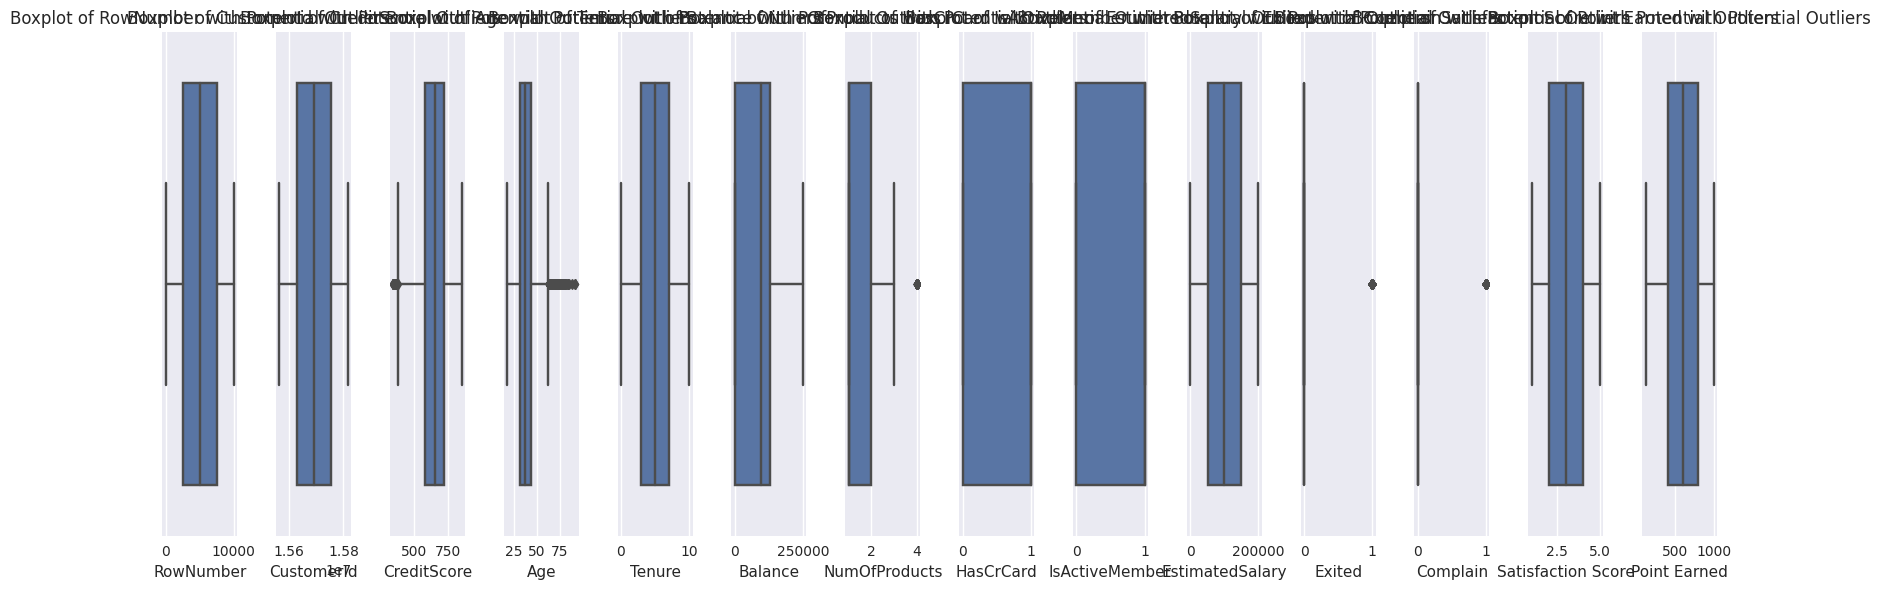

Numerical Variables with Potential Outliers:
CreditScore
Age
NumOfProducts
Exited
Complain


In [351]:
potential_outliers = {}
fig, axes = plt.subplots(nrows=1, ncols=len(numerical), figsize=(16,6))

for i, col in enumerate(numerical):
    Q1 = customer_churn_df[col].quantile(0.25)
    Q3 = customer_churn_df[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    potential_outliers[col] = customer_churn_df[(customer_churn_df[col] < lower_bound) | (customer_churn_df[col] > upper_bound)]

    sns.boxplot(x=customer_churn_df[col], orient="h", ax=axes[i])
    axes[i].set_title(f"Boxplot of {col} with Potential Outliers")

plt.tight_layout()

plt.show()

print("Numerical Variables with Potential Outliers:")
for col, data in potential_outliers.items():
    if not data.empty:
        print(col)

### **A.4** - Chi-Squared Test for Independence

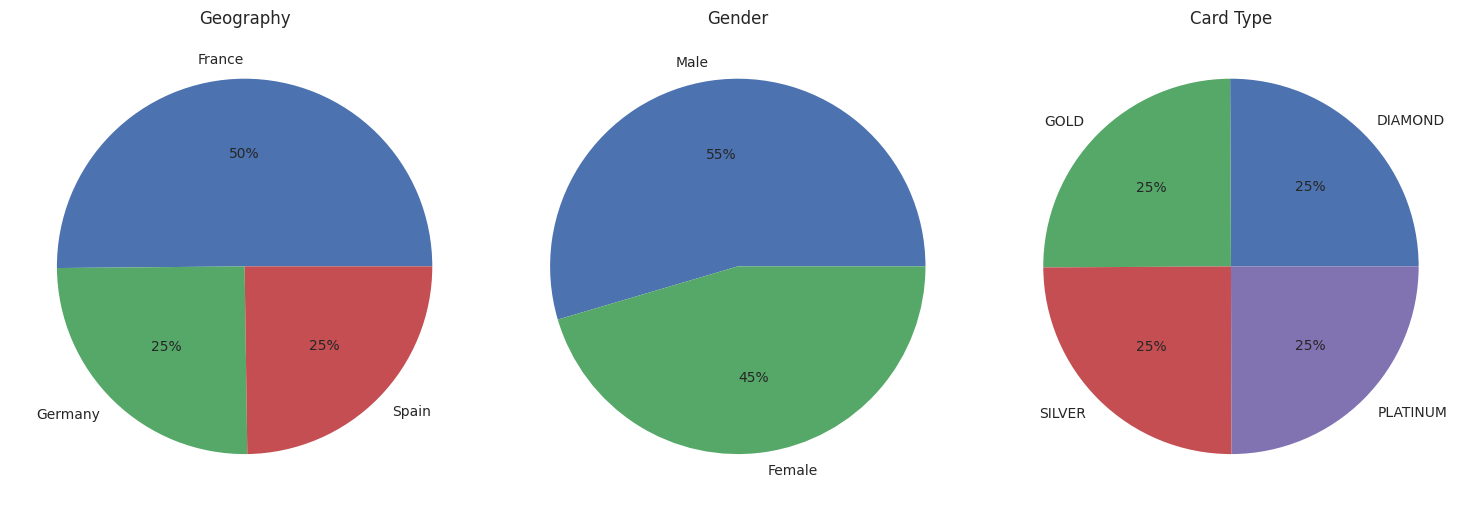

In [358]:
# cat_col = []
# columns = customer_churn_df.columns
# for col in columns:
#     if customer_churn_df[col].dtype == 'object':
#         cat_col.append(col)
# print("Categorical Columns:", cat_col)

# fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# for i in range(len(cat_col)):
#     fracs = list(customer_churn_df[cat_col[i]].value_counts().values)
#     ax[i].pie(x=fracs, labels=customer_churn_df[cat_col[i]].unique(), autopct='%.0f%%')

# plt.tight_layout()
# plt.show()
categorical  = customer_churn_df.select_dtypes('object').columns.tolist()
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

for i in range(len(categorical)):
    value_counts = customer_churn_df[categorical[i]].value_counts(normalize=True)
    fracs = value_counts.values
    labels = value_counts.index
    ax[i].pie(x=fracs, labels=labels, autopct='%.0f%%')
    ax[i].set_title(categorical[i])

plt.tight_layout()
plt.show()

In [88]:
for col in cat_col:
    tab=pd.crosstab(customer_churn_df[col],customer_churn_df['Exited'])
    if st.chi2_contingency(tab)[1]<0.05:
        print(f'{col}: significant')
    else:
        print(f'{col}: not enough proof')


Geography: significant
Gender: significant
Card Type: not enough proof


### **A.7** - Info of clean dataset

In [91]:
build_info_df(customer_churn_df)

data_type  total_observations  missing_val  \
CreditScore            int64               10000            0   
Geography             object               10000            0   
Gender                object               10000            0   
Age                    int64               10000            0   
Tenure                 int64               10000            0   
Balance              float64               10000            0   
NumOfProducts          int64               10000            0   
HasCrCard              int64               10000            0   
IsActiveMember         int64               10000            0   
EstimatedSalary      float64               10000            0   
Exited                 int64               10000            0   
Complain               int64               10000            0   
Satisfaction Score     int64               10000            0   
Card Type             object               10000            0   
Point Earned           int64               10000            0   

                    missing_val_ratio  
CreditScore                         0  
Geography                           0  
Gender                              0  
Age                                 0  
Tenure                              0  
Balance                             0  
NumOfProducts                       0  
HasCrCard                           0  
IsActiveMember                      0  
EstimatedSalary                     0  
Exited                              0  
Complain                            0  
Satisfaction Score                  0  
Card Type                           0  
Point Earned                        0

In [92]:
numeric = [
    "CreditScore",   
    "Age",
    "Tenure",
    "Balance",
    "NumOfProducts",
    "EstimatedSalary",
    "Satisfaction Score",
    "Point Earned",
    "HasCrCard",
    "IsActiveMember",
    "Complain",
]
categorical = [
    "Geography",
    "Gender",
    "Card Type",
]
target = "Exited"

### **A.8** - Describe numeric features

In [93]:
# cheack this columns 
    # CreditScore ->  fine 
    # Age -> there is no outlies because based on the data 
    # NumOfProducts
    # Exited
    # Complain

customer_churn_df[numeric].describe().style.format(thousands=',', precision=2)

### **A.9** -  Describe categorical features

In [94]:
customer_churn_df[categorical] = customer_churn_df[categorical].astype("category")
customer_churn_df[categorical].describe()

Geography Gender Card Type
count      10000  10000     10000
unique         3      2         4
top       France   Male   DIAMOND
freq        5014   5457      2507

In [95]:
customer_churn_df[categorical].head()

Geography  Gender Card Type
0    France  Female   DIAMOND
1     Spain  Female   DIAMOND
2    France  Female   DIAMOND
3    France  Female      GOLD
4     Spain  Female      GOLD

# **B** - Exploratory Data Analysis

### **B.1** -  Exited Class Distribution ->  Target Class

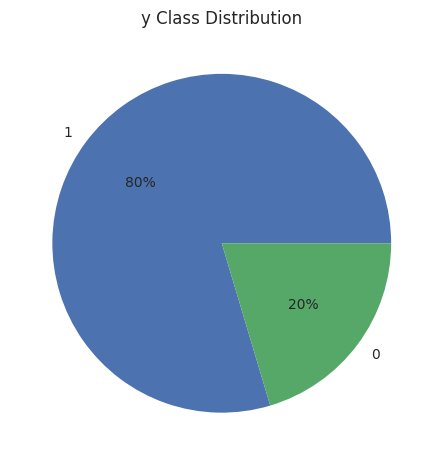

In [96]:
plt.pie(x=customer_churn_df['Exited'].value_counts().values,labels=customer_churn_df['Exited'].unique(),autopct='%.0f%%')
plt.title('y Class Distribution')
plt.show()

### **B.2** -  CreditScore¶

In [97]:
customer_churn_df['CreditScore'].value_counts()

CreditScore
850    233
678     63
655     54
705     53
667     53
      ... 
351      1
365      1
382      1
373      1
419      1
Name: count, Length: 460, dtype: int64

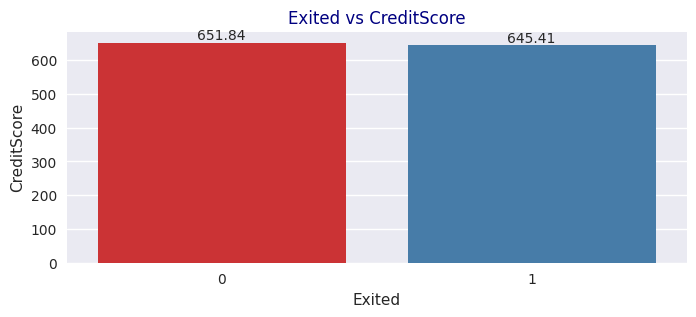

In [98]:
fig, ax = plt.subplots(figsize=(8, 3))
sns.barplot(data=customer_churn_df, x = 'Exited', y = 'CreditScore', errorbar=None, palette="Set1")
plt.title('Exited vs '+ 'CreditScore',color='navy')
ax.bar_label(ax.containers[0], fmt='%0.2f')
plt.show()

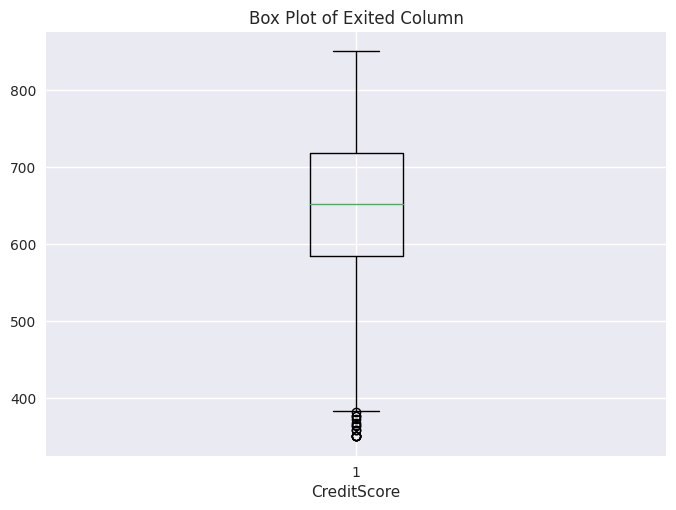

In [99]:
plt.boxplot(customer_churn_df['CreditScore'], vert=True)
plt.title('Box Plot of Exited Column')
plt.xlabel('CreditScore')
plt.show()


### **B.3** - Geography

In [100]:
customer_churn_df['Geography'].value_counts()

Geography
France     5014
Germany    2509
Spain      2477
Name: count, dtype: int64

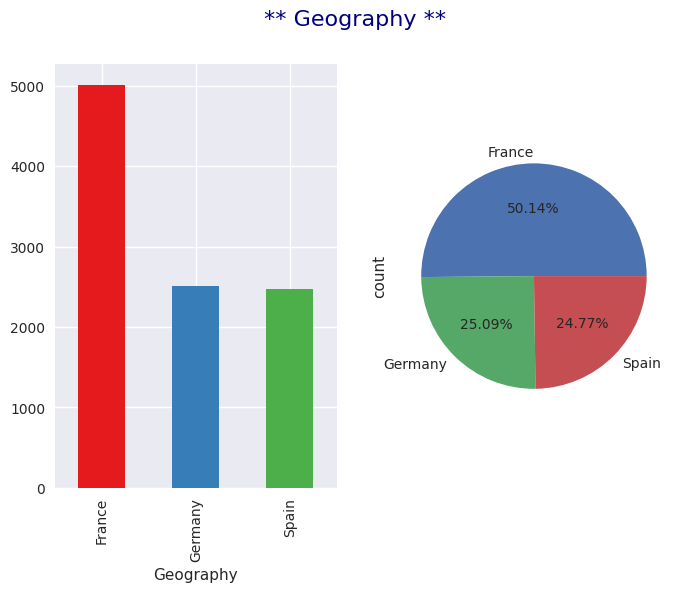

In [101]:
fig, ax = plt.subplots(1, 2) 
fig.suptitle('** ' + 'Geography' + ' **', fontsize=16, color='navy') 
plt.style.use('seaborn')
plt.subplot(1,2,1)
customer_churn_df['Geography'].value_counts().plot(kind='bar',color=sns.color_palette("Set1"))
plt.subplot(1,2,2)
customer_churn_df['Geography'].value_counts().plot(kind='pie',autopct="%.2f%%")
plt.show()

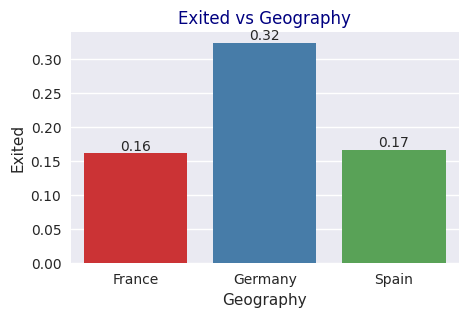

In [102]:
fig, ax = plt.subplots(figsize=(5, 3))
sns.barplot(data=customer_churn_df, x = 'Geography', y = 'Exited', errorbar=None, palette="Set1")
plt.title('Exited vs '+ 'Geography',color='navy')
ax.bar_label(ax.containers[0], fmt='%0.2f')
plt.show()

### **B.4** -  Gender

In [103]:
customer_churn_df['Gender'].value_counts()

Gender
Male      5457
Female    4543
Name: count, dtype: int64

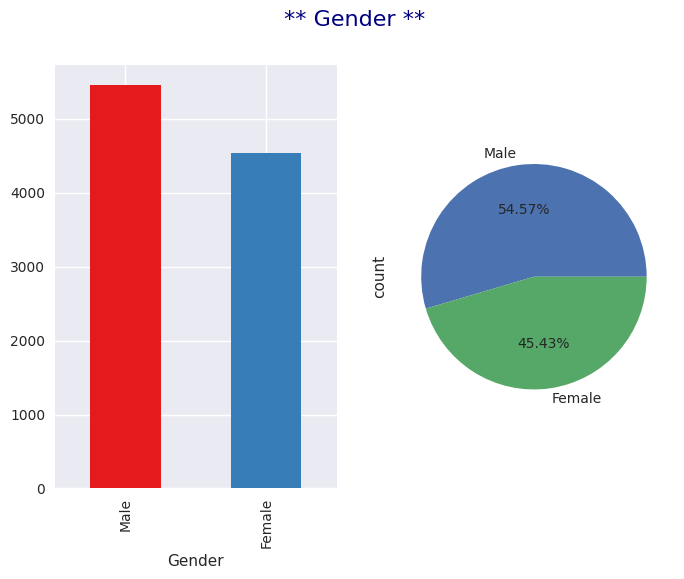

In [104]:
fig, ax = plt.subplots(1, 2) 
fig.suptitle('** ' + 'Gender' + ' **', fontsize=16, color='navy') 
plt.style.use('seaborn')
plt.subplot(1,2,1)
customer_churn_df['Gender'].value_counts().plot(kind='bar',color=sns.color_palette("Set1"))
plt.subplot(1,2,2)
customer_churn_df['Gender'].value_counts().plot(kind='pie',autopct="%.2f%%")
plt.show()

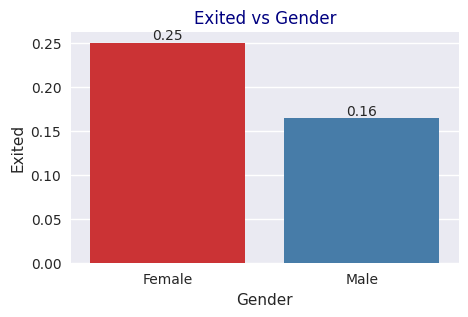

In [105]:
fig, ax = plt.subplots(figsize=(5, 3))
sns.barplot(data=customer_churn_df, x = 'Gender', y = 'Exited', errorbar=None, palette="Set1")
plt.title('Exited vs '+ 'Gender',color='navy')
ax.bar_label(ax.containers[0], fmt='%0.2f')
plt.show()

### **B.5** - Age


In [106]:
customer_churn_df['Age'].value_counts()

Age
37    478
38    477
35    474
36    456
34    447
     ... 
84      2
88      1
82      1
85      1
83      1
Name: count, Length: 70, dtype: int64

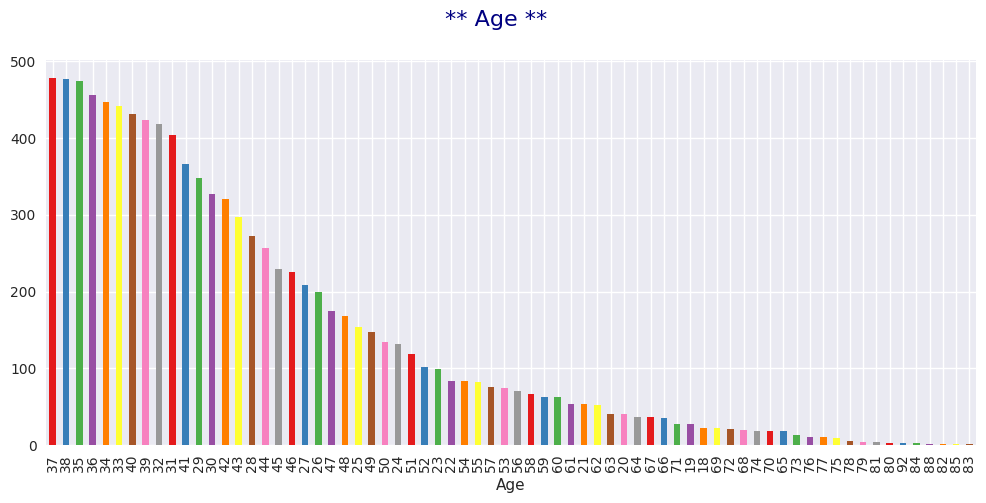

In [107]:
fig, ax = plt.subplots(figsize=(12, 5))
fig.suptitle('** ' + 'Age' + ' **', fontsize=16, color='navy') 
plt.style.use('seaborn')
customer_churn_df['Age'].value_counts().plot(kind='bar',color=sns.color_palette("Set1"))
plt.show()

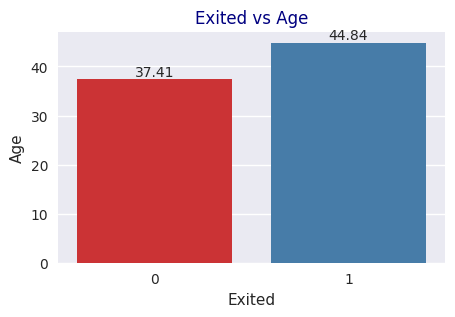

In [108]:
fig, ax = plt.subplots(figsize=(5, 3))
sns.barplot(data=customer_churn_df, x = 'Exited', y = 'Age', errorbar=None, palette="Set1")
plt.title('Exited vs '+ 'Age',color='navy')
ax.bar_label(ax.containers[0], fmt='%0.2f')
plt.show()

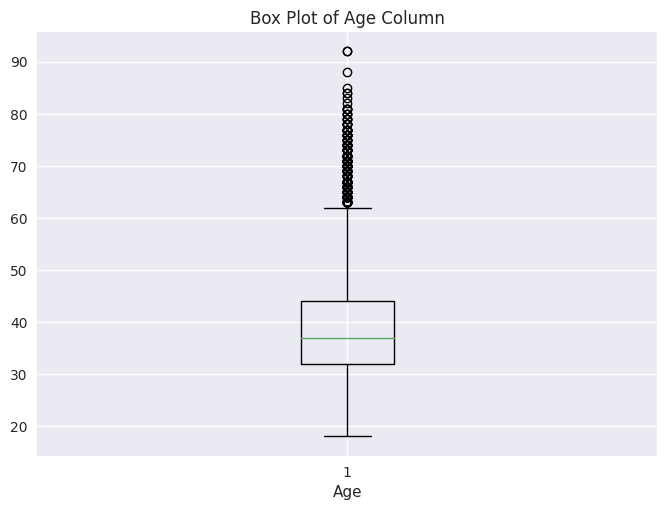

In [109]:
plt.boxplot(customer_churn_df['Age'], vert=True)
plt.title('Box Plot of Age Column')
plt.xlabel('Age')
plt.show()


### **B.6** - NumOfProducts

In [110]:
customer_churn_df['NumOfProducts'].value_counts()

NumOfProducts
1    5084
2    4590
3     266
4      60
Name: count, dtype: int64

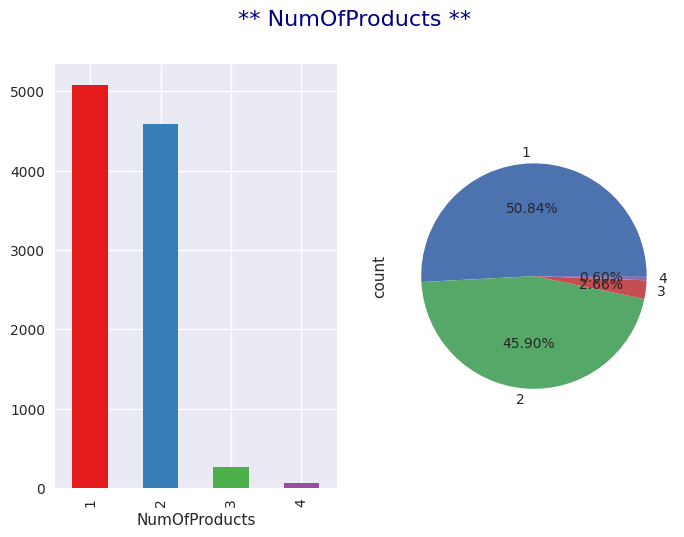

In [111]:
fig, ax = plt.subplots(1, 2) 
fig.suptitle('** ' + 'NumOfProducts' + ' **', fontsize=16, color='navy') 
plt.style.use('seaborn')
plt.subplot(1,2,1)
customer_churn_df['NumOfProducts'].value_counts().plot(kind='bar',color=sns.color_palette("Set1"))
plt.subplot(1,2,2)
customer_churn_df['NumOfProducts'].value_counts().plot(kind='pie',autopct="%.2f%%")
plt.show()

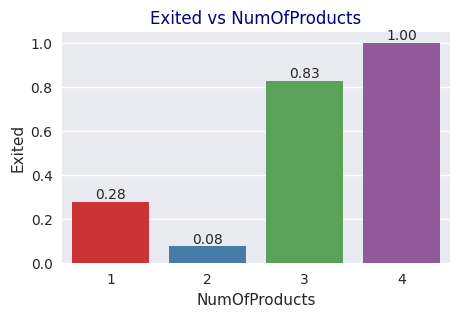

In [112]:
fig, ax = plt.subplots(figsize=(5, 3))
sns.barplot(data=customer_churn_df, x = 'NumOfProducts', y = 'Exited', errorbar=None, palette="Set1")
plt.title('Exited vs '+ 'NumOfProducts',color='navy')
ax.bar_label(ax.containers[0], fmt='%0.2f')
plt.show()

### **B.7** - Box Plots for Numeric Data

In [113]:
fig = make_subplots(rows=4, cols=2)
for i in range(4):
    for j in range(2):
        fig.append_trace(px.box(customer_churn_df[numeric[i + j + 1]]).data[0], row=i+1, col=j+1)
fig.update_layout(height=1000, width=600, title_text="8 Subplots", **layout_options)
fig.update_yaxes(layout_options['yaxis'])
fig.update_xaxes(layout_options['xaxis'])
fig.show()

In [114]:
fig = px.histogram(
    customer_churn_df,
    x="Geography",
    y=target, color="Gender",
    barmode='group',
    histfunc='count',
    width=600
)
fig.update_layout(**layout_options)
fig.show()

In [115]:
fig = px.histogram(
    customer_churn_df,
    x="IsActiveMember",
    y=target, color="Gender",
    barmode='group',
    histfunc='count',
    width=600
)
fig.update_layout(**layout_options)
fig.show()

In [116]:
fig = px.histogram(customer_churn_df, x="Age", color='Gender', nbins=20,
                   width=600, height=400)
fig.update_layout(**layout_options)
fig.show()

In [117]:
fig = px.scatter(customer_churn_df.sample(500), x="EstimatedSalary", y="CreditScore", color='Satisfaction Score',
                   width=600, height=400)
fig.update_layout(**layout_options)
fig.show()

In [118]:
customer_churn_df.head()

CreditScore Geography  Gender  Age  Tenure    Balance  NumOfProducts  \
0          619    France  Female   42       2       0.00              1   
1          608     Spain  Female   41       1   83807.86              1   
2          502    France  Female   42       8  159660.80              3   
3          699    France  Female   39       1       0.00              2   
4          850     Spain  Female   43       2  125510.82              1   

   HasCrCard  IsActiveMember  EstimatedSalary  Exited  Complain  \
0          1               1        101348.88       1         1   
1          0               1        112542.58       0         1   
2          1               0        113931.57       1         1   
3          0               0         93826.63       0         0   
4          1               1         79084.10       0         0   

   Satisfaction Score Card Type  Point Earned  
0                   2   DIAMOND           464  
1                   3   DIAMOND           456  
2                   3   DIAMOND           377  
3                   5      GOLD           350  
4                   5      GOLD           425

In [119]:

corr_matrix = customer_churn_df[numeric + [target]].corr()

In [120]:
fig = px.imshow(corr_matrix, text_auto=True, aspect="auto")
fig.show()

We can find that there is a high correlation between complain parameter and the target variable, so we have to drop this column

In [121]:
customer_churn_df = customer_churn_df.drop('Complain',axis=1)

In [122]:
customer_churn_df.head()

CreditScore Geography  Gender  Age  Tenure    Balance  NumOfProducts  \
0          619    France  Female   42       2       0.00              1   
1          608     Spain  Female   41       1   83807.86              1   
2          502    France  Female   42       8  159660.80              3   
3          699    France  Female   39       1       0.00              2   
4          850     Spain  Female   43       2  125510.82              1   

   HasCrCard  IsActiveMember  EstimatedSalary  Exited  Satisfaction Score  \
0          1               1        101348.88       1                   2   
1          0               1        112542.58       0                   3   
2          1               0        113931.57       1                   3   
3          0               0         93826.63       0                   5   
4          1               1         79084.10       0                   5   

  Card Type  Point Earned  
0   DIAMOND           464  
1   DIAMOND           456  
2   DIAMOND           377  
3      GOLD           350  
4      GOLD           425

#### maping (HasCrCard, IsActiveMember, Complain) features 

In [123]:
CrCd_map = {
    1: "Yes",
    0: "No"
}
activation_map = {
    1: "Yes",
    0: "No"
}


customer_churn_df["IsActiveMember"] = customer_churn_df["IsActiveMember"].map(activation_map)
customer_churn_df["HasCrCard"] = customer_churn_df["HasCrCard"].map(CrCd_map)


In [124]:
customer_churn_df.head()

CreditScore Geography  Gender  Age  Tenure    Balance  NumOfProducts  \
0          619    France  Female   42       2       0.00              1   
1          608     Spain  Female   41       1   83807.86              1   
2          502    France  Female   42       8  159660.80              3   
3          699    France  Female   39       1       0.00              2   
4          850     Spain  Female   43       2  125510.82              1   

  HasCrCard IsActiveMember  EstimatedSalary  Exited  Satisfaction Score  \
0       Yes            Yes        101348.88       1                   2   
1        No            Yes        112542.58       0                   3   
2       Yes             No        113931.57       1                   3   
3        No             No         93826.63       0                   5   
4       Yes            Yes         79084.10       0                   5   

  Card Type  Point Earned  
0   DIAMOND           464  
1   DIAMOND           456  
2   DIAMOND           377  
3      GOLD           350  
4      GOLD           425

In [125]:
# X = df[['Gender', 'Balance', 'NumOfProducts', 'Age', 'Geography', 'EstimatedSalary']]
# y = df['Exited']

numeric = [
    "CreditScore",   
    "Age",
    "Tenure",
    "Balance",
    "NumOfProducts",
    "EstimatedSalary",
    "Satisfaction Score",
    "Point Earned",
]
categorical = [
    "Geography",
    "Gender",
    "Card Type",
    "HasCrCard",
    "IsActiveMember",
]
target = "Exited"

In [126]:
customer_churn_df[categorical].head()

Geography  Gender Card Type HasCrCard IsActiveMember
0    France  Female   DIAMOND       Yes            Yes
1     Spain  Female   DIAMOND        No            Yes
2    France  Female   DIAMOND       Yes             No
3    France  Female      GOLD        No             No
4     Spain  Female      GOLD       Yes            Yes

## B-Feature Engineering

#### 1- Balance salary rate 
The ratio of the account balance to the estimated salary of the customer.

In [127]:
customer_churn_df['balance_salary_rate'] = customer_churn_df.Balance / customer_churn_df.EstimatedSalary
customer_churn_df.head()

CreditScore Geography  Gender  Age  Tenure    Balance  NumOfProducts  \
0          619    France  Female   42       2       0.00              1   
1          608     Spain  Female   41       1   83807.86              1   
2          502    France  Female   42       8  159660.80              3   
3          699    France  Female   39       1       0.00              2   
4          850     Spain  Female   43       2  125510.82              1   

  HasCrCard IsActiveMember  EstimatedSalary  Exited  Satisfaction Score  \
0       Yes            Yes        101348.88       1                   2   
1        No            Yes        112542.58       0                   3   
2       Yes             No        113931.57       1                   3   
3        No             No         93826.63       0                   5   
4       Yes            Yes         79084.10       0                   5   

  Card Type  Point Earned  balance_salary_rate  
0   DIAMOND           464             0.000000  
1   DIAMOND           456             0.744677  
2   DIAMOND           377             1.401375  
3      GOLD           350             0.000000  
4      GOLD           425             1.587055

In [128]:
customer_churn_df.columns

Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Exited', 'Satisfaction Score', 'Card Type', 'Point Earned',
       'balance_salary_rate'],
      dtype='object')

In [129]:
def product_utilization_rate_by_year(row):
    number_of_products = row.NumOfProducts
    tenure = row.Tenure
    
    if number_of_products == 0:
        return 0
    
    if tenure == 0:
        return number_of_products
    
    rate = number_of_products / tenure
    return rate

#### 2- Product utilization rate by year
The ratio of the number of products used by the customer to the number of years they have been a customer.

In [130]:
customer_churn_df = customer_churn_df.assign(product_utilization_rate_by_year=customer_churn_df.apply(lambda x: product_utilization_rate_by_year(x), axis=1)) 
customer_churn_df.head()

CreditScore Geography  Gender  Age  Tenure    Balance  NumOfProducts  \
0          619    France  Female   42       2       0.00              1   
1          608     Spain  Female   41       1   83807.86              1   
2          502    France  Female   42       8  159660.80              3   
3          699    France  Female   39       1       0.00              2   
4          850     Spain  Female   43       2  125510.82              1   

  HasCrCard IsActiveMember  EstimatedSalary  Exited  Satisfaction Score  \
0       Yes            Yes        101348.88       1                   2   
1        No            Yes        112542.58       0                   3   
2       Yes             No        113931.57       1                   3   
3        No             No         93826.63       0                   5   
4       Yes            Yes         79084.10       0                   5   

  Card Type  Point Earned  balance_salary_rate  \
0   DIAMOND           464             0.000000   
1   DIAMOND           456             0.744677   
2   DIAMOND           377             1.401375   
3      GOLD           350             0.000000   
4      GOLD           425             1.587055   

   product_utilization_rate_by_year  
0                             0.500  
1                             1.000  
2                             0.375  
3                             2.000  
4                             0.500

#### 3- Tenure rate by age
The ratio of the number of years the customer has been a customer to their age minus 17 (to exclude the teenage years).

In [131]:
customer_churn_df['tenure_rate_by_age'] = customer_churn_df.Tenure / (customer_churn_df.Age-17)
customer_churn_df.head()

CreditScore Geography  Gender  Age  Tenure    Balance  NumOfProducts  \
0          619    France  Female   42       2       0.00              1   
1          608     Spain  Female   41       1   83807.86              1   
2          502    France  Female   42       8  159660.80              3   
3          699    France  Female   39       1       0.00              2   
4          850     Spain  Female   43       2  125510.82              1   

  HasCrCard IsActiveMember  EstimatedSalary  Exited  Satisfaction Score  \
0       Yes            Yes        101348.88       1                   2   
1        No            Yes        112542.58       0                   3   
2       Yes             No        113931.57       1                   3   
3        No             No         93826.63       0                   5   
4       Yes            Yes         79084.10       0                   5   

  Card Type  Point Earned  balance_salary_rate  \
0   DIAMOND           464             0.000000   
1   DIAMOND           456             0.744677   
2   DIAMOND           377             1.401375   
3      GOLD           350             0.000000   
4      GOLD           425             1.587055   

   product_utilization_rate_by_year  tenure_rate_by_age  
0                             0.500            0.080000  
1                             1.000            0.041667  
2                             0.375            0.320000  
3                             2.000            0.045455  
4                             0.500            0.076923

#### 4- Credit score rate by salary
The ratio of the customer's credit score to their estimated salary.

In [132]:
customer_churn_df['credit_score_rate_by_age'] = customer_churn_df.CreditScore / (customer_churn_df.EstimatedSalary)
customer_churn_df.head()

CreditScore Geography  Gender  Age  Tenure    Balance  NumOfProducts  \
0          619    France  Female   42       2       0.00              1   
1          608     Spain  Female   41       1   83807.86              1   
2          502    France  Female   42       8  159660.80              3   
3          699    France  Female   39       1       0.00              2   
4          850     Spain  Female   43       2  125510.82              1   

  HasCrCard IsActiveMember  EstimatedSalary  Exited  Satisfaction Score  \
0       Yes            Yes        101348.88       1                   2   
1        No            Yes        112542.58       0                   3   
2       Yes             No        113931.57       1                   3   
3        No             No         93826.63       0                   5   
4       Yes            Yes         79084.10       0                   5   

  Card Type  Point Earned  balance_salary_rate  \
0   DIAMOND           464             0.000000   
1   DIAMOND           456             0.744677   
2   DIAMOND           377             1.401375   
3      GOLD           350             0.000000   
4      GOLD           425             1.587055   

   product_utilization_rate_by_year  tenure_rate_by_age  \
0                             0.500            0.080000   
1                             1.000            0.041667   
2                             0.375            0.320000   
3                             2.000            0.045455   
4                             0.500            0.076923   

   credit_score_rate_by_age  
0                  0.006108  
1                  0.005402  
2                  0.004406  
3                  0.007450  
4                  0.010748

#### 5-Countries monthly average salaries 
The estimated monthly average salary for the country of the customer.

In [133]:
def countries_monthly_average_salaries(row):
    #brutto datas from  https://tr.wikipedia.org/wiki/Aylık_ortalama_ücretlerine_göre_Avrupa_ülkeleri_listesi
    fr = 3696    
    de = 4740
    sp = 2257
    salary = row.EstimatedSalary / 12
    country = row.Geography              # Germany, France and Spain
    
    if country == 'Germany':
        return salary / de
    elif country == "France":
        return salary / fr
    elif country == "Spain": 
        return salary / sp

In [134]:
customer_churn_df = customer_churn_df.assign(countries_monthly_average_salaries = customer_churn_df.apply(lambda x: countries_monthly_average_salaries(x), axis=1)) 
customer_churn_df.head()

CreditScore Geography  Gender  Age  Tenure    Balance  NumOfProducts  \
0          619    France  Female   42       2       0.00              1   
1          608     Spain  Female   41       1   83807.86              1   
2          502    France  Female   42       8  159660.80              3   
3          699    France  Female   39       1       0.00              2   
4          850     Spain  Female   43       2  125510.82              1   

  HasCrCard IsActiveMember  EstimatedSalary  Exited  Satisfaction Score  \
0       Yes            Yes        101348.88       1                   2   
1        No            Yes        112542.58       0                   3   
2       Yes             No        113931.57       1                   3   
3        No             No         93826.63       0                   5   
4       Yes            Yes         79084.10       0                   5   

  Card Type  Point Earned  balance_salary_rate  \
0   DIAMOND           464             0.000000   
1   DIAMOND           456             0.744677   
2   DIAMOND           377             1.401375   
3      GOLD           350             0.000000   
4      GOLD           425             1.587055   

   product_utilization_rate_by_year  tenure_rate_by_age  \
0                             0.500            0.080000   
1                             1.000            0.041667   
2                             0.375            0.320000   
3                             2.000            0.045455   
4                             0.500            0.076923   

   credit_score_rate_by_age  countries_monthly_average_salaries  
0                  0.006108                            2.285103  
1                  0.005402                            4.155316  
2                  0.004406                            2.568803  
3                  0.007450                            2.115499  
4                  0.010748                            2.919956

####  6-Credit Score grouping ( min= 358 and max= 800)


In [135]:
# def credit_score_table(row):
    
#     credit_score = row.CreditScore
#     if credit_score >= 300 and credit_score < 500:
#         return "Very_Poor"
#     elif credit_score >= 500 and credit_score < 601:
#         return "Poor"
#     elif credit_score >= 601 and credit_score < 661:
#         return "Fair"
#     elif credit_score >= 661 and credit_score < 781:
#         return "Good"
#     elif credit_score >= 851:
#         return "Top"
#     elif credit_score >= 781 and credit_score < 851:
#         return "Excellent"
#     elif credit_score < 300:
#         return "Deep"

In [136]:
# customer_churn_df = customer_churn_df.assign(credit_score_table=customer_churn_df.apply(lambda x: credit_score_table(x), axis=1))
# customer_churn_df.head()

### one hot encoding 

In [137]:
customer_churn_df = pd.get_dummies(customer_churn_df,dtype=int)

### C- Data Preproccessing

الأعلى من 1 تعني أن العميل يكسب أكثر من المتوسط، في حين أن النسبة الأقل من 1 تعني أنه يكسب أقل.

In [138]:
customer_churn_df.head()

CreditScore  Age  Tenure    Balance  NumOfProducts  EstimatedSalary  \
0          619   42       2       0.00              1        101348.88   
1          608   41       1   83807.86              1        112542.58   
2          502   42       8  159660.80              3        113931.57   
3          699   39       1       0.00              2         93826.63   
4          850   43       2  125510.82              1         79084.10   

   Exited  Satisfaction Score  Point Earned  balance_salary_rate  ...  \
0       1                   2           464             0.000000  ...   
1       0                   3           456             0.744677  ...   
2       1                   3           377             1.401375  ...   
3       0                   5           350             0.000000  ...   
4       0                   5           425             1.587055  ...   

   Gender_Female  Gender_Male  HasCrCard_No  HasCrCard_Yes  IsActiveMember_No  \
0              1            0             0              1                  0   
1              1            0             1              0                  0   
2              1            0             0              1                  1   
3              1            0             1              0                  1   
4              1            0             0              1                  0   

   IsActiveMember_Yes  Card Type_DIAMOND  Card Type_GOLD  Card Type_PLATINUM  \
0                   1                  1               0                   0   
1                   1                  1               0                   0   
2                   0                  1               0                   0   
3                   0                  0               1                   0   
4                   1                  0               1                   0   

   Card Type_SILVER  
0                 0  
1                 0  
2                 0  
3                 0  
4                 0  

[5 rows x 27 columns]

In [139]:
numeric = [
    "CreditScore",   
    "Age",
    "Tenure",
    "Balance",
    "NumOfProducts",
    "EstimatedSalary",
    "Satisfaction Score",
    "Point Earned",
    "balance_salary_rate",
    "credit_score_rate_by_age",
    "tenure_rate_by_age",
    "product_utilization_rate_by_year",
    "countries_monthly_average_salaries"
]

In [140]:
customer_churn_df[numeric].describe().style.format(thousands=',', precision=2)

In [141]:
customer_churn_df.head()

CreditScore  Age  Tenure    Balance  NumOfProducts  EstimatedSalary  \
0          619   42       2       0.00              1        101348.88   
1          608   41       1   83807.86              1        112542.58   
2          502   42       8  159660.80              3        113931.57   
3          699   39       1       0.00              2         93826.63   
4          850   43       2  125510.82              1         79084.10   

   Exited  Satisfaction Score  Point Earned  balance_salary_rate  ...  \
0       1                   2           464             0.000000  ...   
1       0                   3           456             0.744677  ...   
2       1                   3           377             1.401375  ...   
3       0                   5           350             0.000000  ...   
4       0                   5           425             1.587055  ...   

   Gender_Female  Gender_Male  HasCrCard_No  HasCrCard_Yes  IsActiveMember_No  \
0              1            0             0              1                  0   
1              1            0             1              0                  0   
2              1            0             0              1                  1   
3              1            0             1              0                  1   
4              1            0             0              1                  0   

   IsActiveMember_Yes  Card Type_DIAMOND  Card Type_GOLD  Card Type_PLATINUM  \
0                   1                  1               0                   0   
1                   1                  1               0                   0   
2                   0                  1               0                   0   
3                   0                  0               1                   0   
4                   1                  0               1                   0   

   Card Type_SILVER  
0                 0  
1                 0  
2                 0  
3                 0  
4                 0  

[5 rows x 27 columns]

### Base Line

In [142]:
def fetch_logged_data(run_id):
    client = MlflowClient()
    data = client.get_run(run_id).data
    tags = {k: v for k, v in data.tags.items() if not k.startswith("mlflow.")}
    artifacts = [f.path for f in client.list_artifacts(run_id, "model")]
    return data.params, data.metrics, tags, artifacts




def train_and_eval(model,  X_train,Y_train, X_test, Y_test, model_name=None):

    # fit the model on X_train and y_train
    fit_data = None
    with mlflow.start_run() as run:
        fit_data = model.fit(X_train, Y_train)
    fetch_logged_data(run.info.run_id)
    
    # predcit using X_test
    predict_test = model.predict(X_test.values)

    #calcutate the accuracy_score
    accuracy = accuracy_score(Y_test, predict_test)
    
    #calcutate the f1 score
    f1 = f1_score(Y_test, predict_test)

    print("Accuracy is ", accuracy)
    print('F1 score is', f1)
    

    # roc curve
    if model_name == "LogisticRegression" or model_name == "SVC" : 
        y_score_model = model.fit(X_train, Y_train).decision_function(X_test.values)
        fpr_lr, tpr_lr, _ = roc_curve(Y_test, y_score_model)
        # auc
        roc_auc_lr =auc(fpr_lr, tpr_lr)
        print('area under roc is', roc_auc_lr)

        plt.figure()
        plt.xlim([-0.01, 1.00])
        plt.ylim([-0.01, 1.01])
        plt.plot(fpr_lr, tpr_lr, lw=3, label='LogRegr ROC curve (area = {:0.2f})'.format(roc_auc_lr))
        plt.xlabel('False Positive Rate', fontsize=16)
        plt.ylabel('True Positive Rate', fontsize=16)
        plt.title('ROC curve ', fontsize=16)
        plt.legend(loc='lower right', fontsize=13)
        plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
        plt.show()
    
def evaluate_and_plot_importance(model, X_train, Y_train, feature_names, model_name):
    model.fit(X_train, Y_train)

    # Determine if model has 'feature_importances_' or 'coef_' attribute
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    elif hasattr(model, 'coef_'):
        # Handle models with multiple classes
        if model.coef_.shape[0] > 1:
            importances = np.abs(model.coef_).sum(axis=0)
        else:
            importances = np.abs(model.coef_[0])
    else:
        # For models that do not have feature_importances_ or coef_ attributes
        print(f"No feature importances or coefficients available for {model_name}.")
        return

    indices = np.argsort(importances)[::-1]

    plt.figure(figsize=(10, 6))
    plt.title(f"Feature Importances for {model_name}")
    plt.bar(range(len(indices)), importances[indices], color="b", align="center")
    plt.xticks(range(len(indices)), [feature_names[i] for i in indices], rotation=90)
    plt.xlim([-1, len(indices)])
    plt.show()

In [143]:
X_train, X_test, y_train, y_test = train_test_split(customer_churn_df[numeric], customer_churn_df[target], random_state=42, stratify=customer_churn_df[target])

In [144]:
pipeline_lr=Pipeline([("lr_scalar",StandardScaler()),
                     ("lr",LogisticRegression())])

pipeline_dt=Pipeline([("dt_scalar",StandardScaler()),
                     ("dt",DecisionTreeClassifier())])

pipeline_rf=Pipeline([("rf_sacalat",StandardScaler()),
                     ("rf",RandomForestClassifier())])


pipeline_kn=Pipeline([("knn_sclalar",StandardScaler()),
                     ("kn",KNeighborsClassifier())])

pipeline_xgb = Pipeline([("xgb_scalar",StandardScaler()),
                     ("xgb",XGBClassifier())])

pipeline_svm=Pipeline([('svc_scalar',StandardScaler()),
                       ('svm',SVC(probability=True))])

pipeline_gnb=Pipeline([('gnb_scalar',StandardScaler()),
                       ('GaussianNB', GaussianNB())])

pipeline_cat=Pipeline([('cat_scalar',StandardScaler()),
                       ('CatBoostClassifier', CatBoostClassifier(verbose=False))])

pipeline_GBM=Pipeline([('gbm_scalar',StandardScaler()),
                       ('GradientBoostingClassifier', GradientBoostingClassifier())])

pipeline_LightGBM=Pipeline([('lgbm_scalar',StandardScaler()),
                       ('LGBMClassifier', LGBMClassifier())])


pipelines = [pipeline_lr, pipeline_dt, pipeline_rf, pipeline_kn, pipeline_xgb,pipeline_svm, pipeline_gnb,pipeline_cat,pipeline_GBM,pipeline_LightGBM]


In [145]:
 pipeline_dict = {0: "LogisticRegression", 1: "DecisionTree", 2:
                  "RandomForest",3: "KNeighbors", 4: "XGBClassifier", 
                  5 : 'SVC', 6: 'GaussianNB',7:'CatBoostClassifier',8:'GradientBoostingClassifier',9:'LGBMClassifier'}

Model Name :  LogisticRegression
Accuracy is  0.786
F1 score is 0.08547008547008547
area under roc is 0.7366873918882514


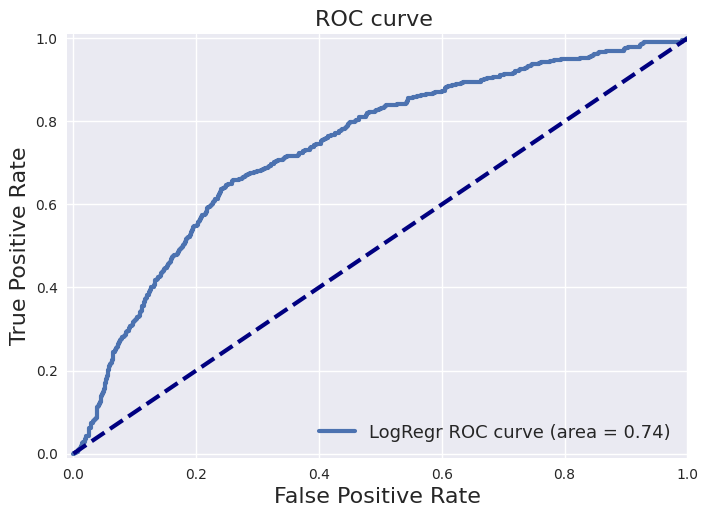


Model Name :  DecisionTree
Accuracy is  0.7656
F1 score is 0.44612476370510395

Model Name :  RandomForest
Accuracy is  0.8412
F1 score is 0.4993694829760404

Model Name :  KNeighbors
Accuracy is  0.8248
F1 score is 0.44836272040302266

Model Name :  XGBClassifier
Accuracy is  0.8436
F1 score is 0.5383707201889021

Model Name :  SVC
Accuracy is  0.8272
F1 score is 0.3099041533546326
area under roc is 0.8107258695564225


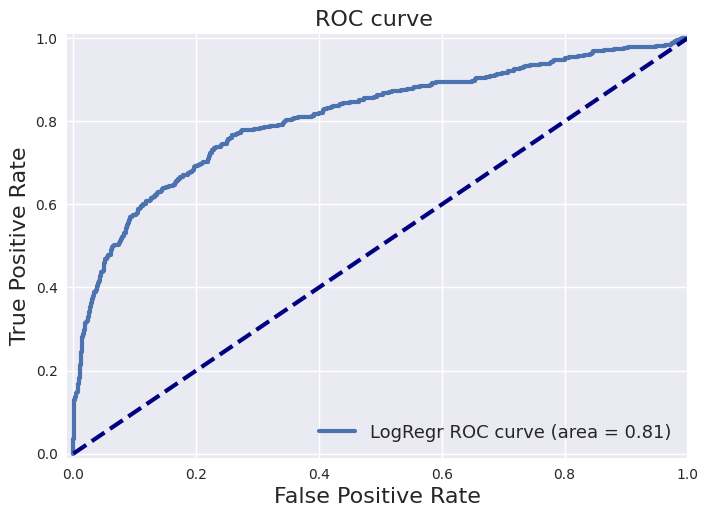


Model Name :  GaussianNB
Accuracy is  0.7936
F1 score is 0.06521739130434782

Model Name :  CatBoostClassifier
Accuracy is  0.8496
F1 score is 0.5414634146341464

Model Name :  GradientBoostingClassifier
Accuracy is  0.8488
F1 score is 0.5489260143198091

Model Name :  LGBMClassifier
[LightGBM] [Info] Number of positive: 1529, number of negative: 5971
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001435 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2143
[LightGBM] [Info] Number of data points in the train set: 7500, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203867 -> initscore=-1.362300
[LightGBM] [Info] Start training from score -1.362300
Accuracy is  0.8464
F1 score is 0.5362318840579711



In [146]:
for i, model in enumerate(pipelines):
    print("Model Name : ",pipeline_dict[i])
    train_and_eval(model, X_train.values, y_train, X_test, y_test, model_name=pipeline_dict[i])
    print()

-  Know best Feature for each model

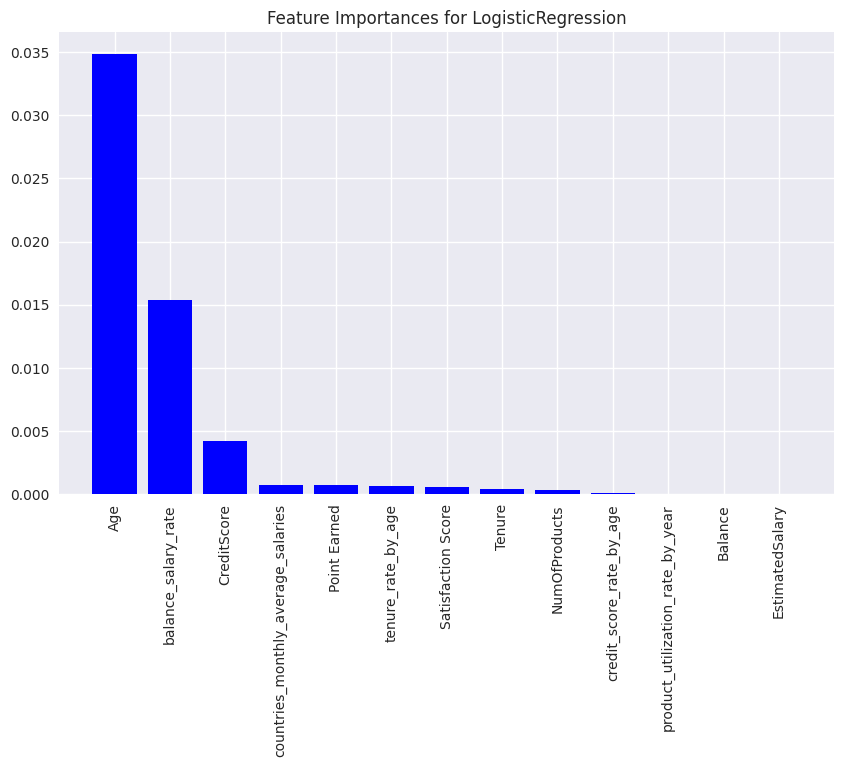

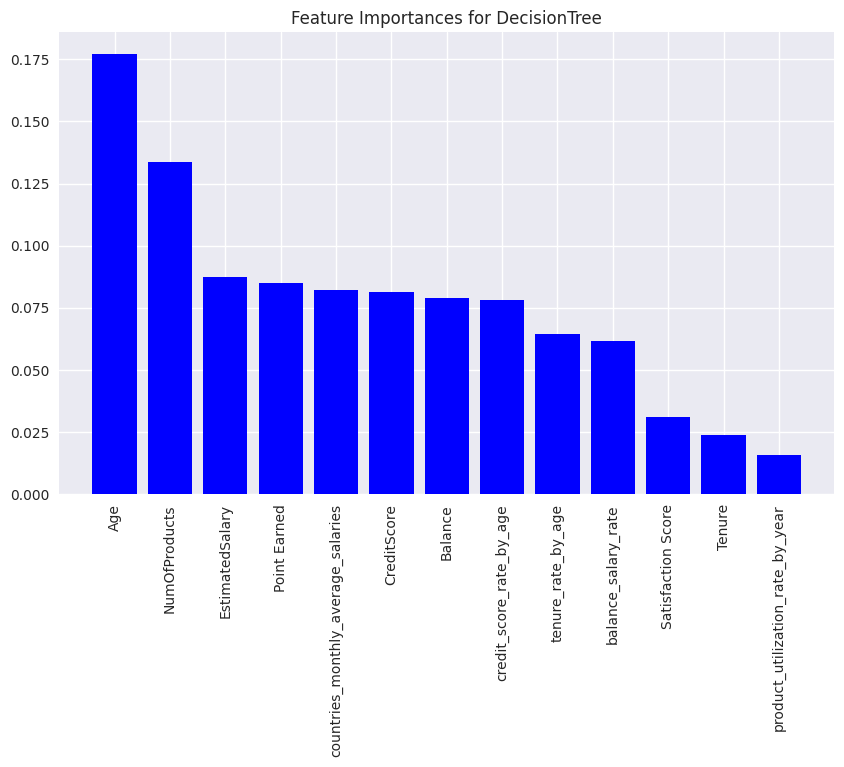

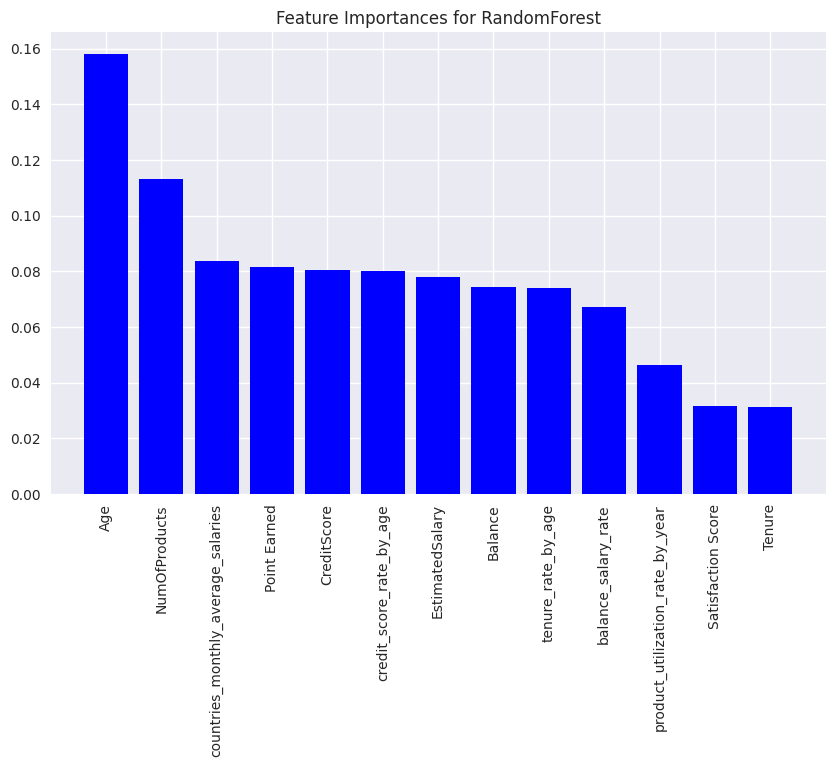

No feature importances or coefficients available for KNeighbors.


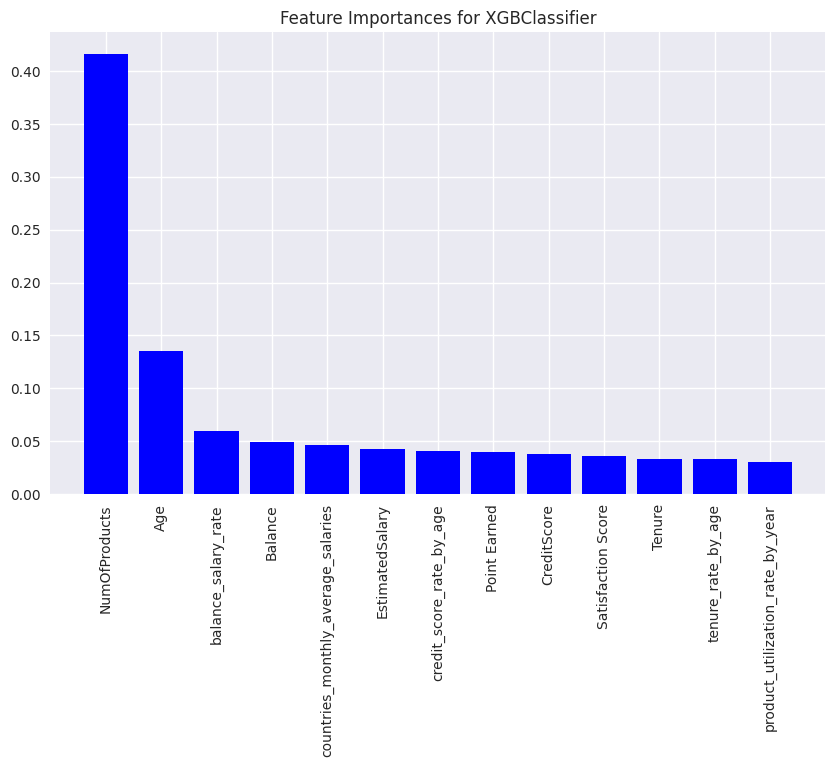

No feature importances or coefficients available for SVC.
No feature importances or coefficients available for GaussianNB.


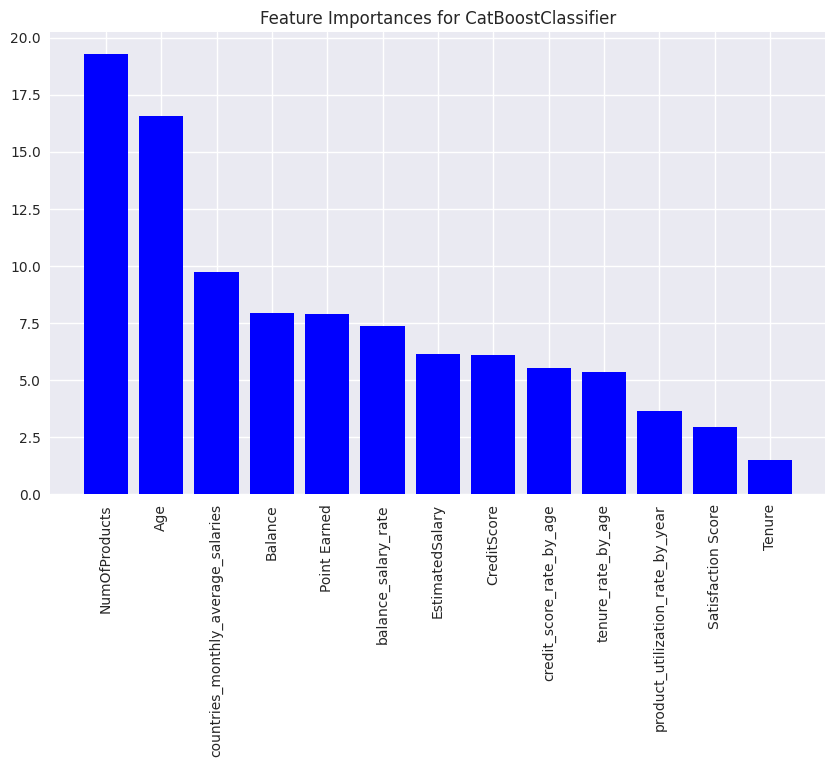

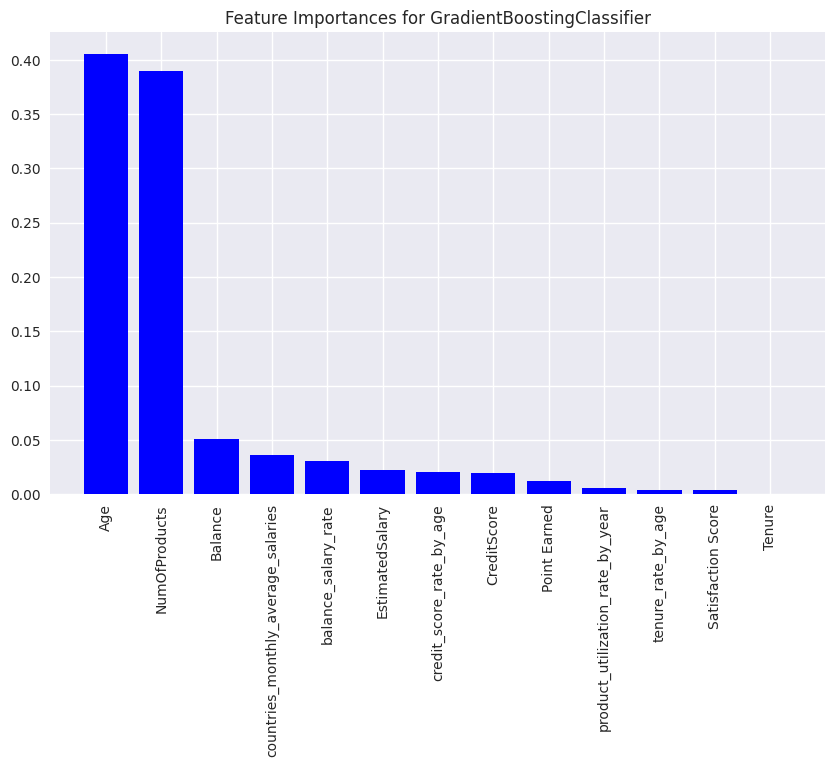

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1529, number of negative: 5971
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001328 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2138
[LightGBM] [Info] Number of data points in the train set: 7500, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203867 -> initscore=-1.362300
[LightGBM] [Info] Start training from score -1.362300


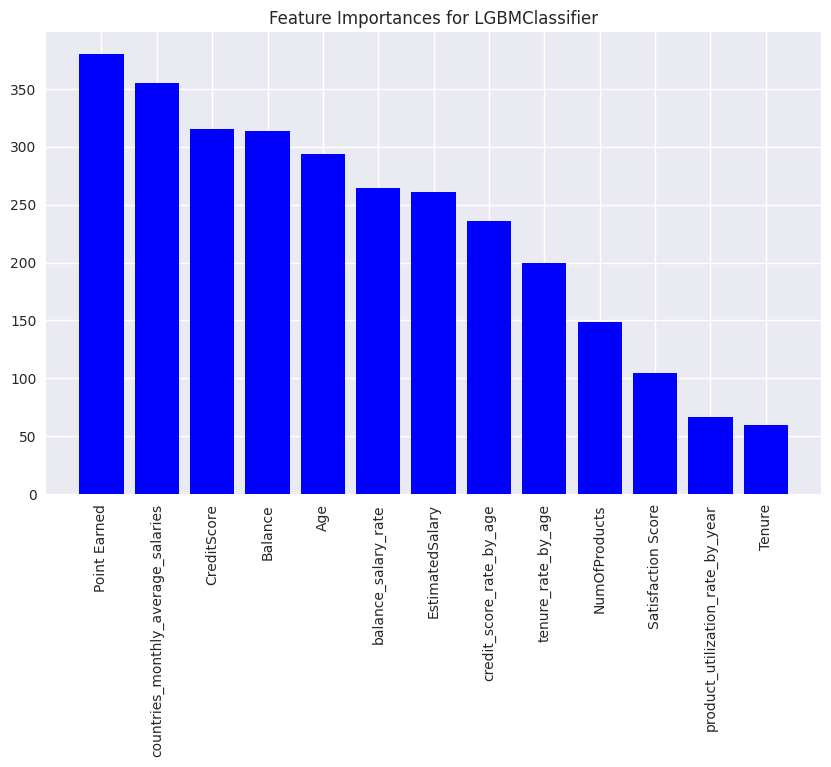

In [147]:
for i, pipeline in enumerate(pipelines):
    model = pipeline.steps[-1][1]  
    model_name = pipeline_dict[i]  
    evaluate_and_plot_importance(model, X_train, y_train, X_train.columns, model_name)

Based on the previous results we can notice that the recall metric is too low for every model so we have to find a way to fix this problem.
we can try grid search to find the best hyper paramters that increase the value of recall and f1-score.

In [148]:
def grid_search_evaluation(model,params,X_train,y_train,X_test,y_test,cv=5):
    grid_search = GridSearchCV(model, params,scoring='f1',cv=cv, verbose=1,n_jobs=-1)
    train_and_eval(grid_search, X_train, y_train, X_test, y_test, model_name="")
    print(grid_search.best_estimator_)
    print(grid_search.best_params_)
    print(grid_search.score(X_test,y_test))

In [149]:
lr_params = [
    {
        "lr__C": [0.1,0.3,0.5,0.8,1],
        "lr__penalty": ['l1','l2'],
    },
]

grid_search_evaluation(pipeline_lr,lr_params,X_train,y_train,X_test,y_test,cv = 10)


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Accuracy is  0.786
F1 score is 0.08547008547008547
Pipeline(steps=[('lr_scalar', StandardScaler()),
                ('lr', LogisticRegression(C=0.8))])
{'lr__C': 0.8, 'lr__penalty': 'l2'}
0.08547008547008547


In [151]:
dt_params =  {
    'dt__max_depth': [3, 4, 5, 6, 7, 9, 11],
    'dt__min_samples_split': [2, 3, 4, 5, 6, 7],
    'dt__criterion': ['entropy', 'gini']
}

grid_search_evaluation(pipeline_dt,dt_params,X_train,y_train,X_test,y_test,cv = 3)

Fitting 3 folds for each of 84 candidates, totalling 252 fits
Accuracy is  0.8384
F1 score is 0.5835051546391753
Pipeline(steps=[('dt_scalar', StandardScaler()),
                ('dt',
                 DecisionTreeClassifier(criterion='entropy', max_depth=4))])
{'dt__criterion': 'entropy', 'dt__max_depth': 4, 'dt__min_samples_split': 2}
0.5835051546391753


In [153]:
k_range = list(range(1, 31))
weight_options = ['uniform', 'distance']
p=[1,2]
algorithm = ["ball_tree", "kd_tree", "brute"]
knn_params = [
    {
        "kn__n_neighbors":k_range,
        "kn__weights":weight_options,
        "kn__p":p,
        "kn__algorithm":algorithm
    },
]
grid_search_evaluation(pipeline_kn,knn_params,X_train,y_train,X_test,y_test,cv = 3)

Fitting 3 folds for each of 360 candidates, totalling 1080 fits
Accuracy is  0.8088
F1 score is 0.4402810304449648
Pipeline(steps=[('knn_sclalar', StandardScaler()),
                ('kn',
                 KNeighborsClassifier(algorithm='ball_tree', n_neighbors=4,
                                      weights='distance'))])
{'kn__algorithm': 'ball_tree', 'kn__n_neighbors': 4, 'kn__p': 2, 'kn__weights': 'distance'}
0.4402810304449648


In [154]:
nb_params = {
    'GaussianNB__var_smoothing': np.logspace(0,-9, num=100)
}
grid_search_evaluation(pipeline_gnb, nb_params,X_train,y_train,X_test,y_test,cv = 3)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Accuracy is  0.7956
F1 score is 0.05545286506469502
Pipeline(steps=[('gnb_scalar', StandardScaler()),
                ('GaussianNB', GaussianNB(var_smoothing=0.05336699231206309))])
{'GaussianNB__var_smoothing': 0.05336699231206309}
0.05545286506469502


In [156]:
svm_params = {'svm__C': [0.1, 1, 10, 100, 1000], 
              'svm__gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'svm__kernel': [ "rbf",]} 
grid_search_evaluation(pipeline_svm, svm_params,X_train,y_train,X_test,y_test,cv = 3)

Fitting 3 folds for each of 25 candidates, totalling 75 fits
Accuracy is  0.8472
F1 score is 0.5213032581453634
Pipeline(steps=[('svc_scalar', StandardScaler()),
                ('svm', SVC(C=10, gamma=0.1, probability=True))])
{'svm__C': 10, 'svm__gamma': 0.1, 'svm__kernel': 'rbf'}
0.5213032581453634


In [159]:
xgb_params = [{
    'xgb__gamma': [0, 0.2, 0.8, 3.2],
    'xgb__learning_rate': [0.01, 0.06, 0.1, 0.2],
    'xgb__max_depth': [5, 7, 9],
    'xgb__n_estimators': [50, 80, 100],
    'xgb__reg_alpha': [0, 0.2, 0.8, 1.6],
    'xgb__reg_lambda': [0, 0.2, 0.8, 1.6]
}]

grid_search_evaluation(pipeline_xgb, xgb_params,X_train,y_train,X_test,y_test,cv = 3)


Fitting 3 folds for each of 2304 candidates, totalling 6912 fits
Accuracy is  0.8428
F1 score is 0.5293413173652693
Pipeline(steps=[('xgb_scalar', StandardScaler()),
                ('xgb',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=0.8, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=9, max_leaves=None,
                               min

In [163]:
n_estimators = [1, 4, 8, 16, 32, 64 ,200]
max_depth = list(range(1, 10))
min_samples_split = [2, 5, 10,  100]
min_samples_leaf = [1, 3 ,7, 10] 
rf_params = [
    {
        "rf__n_estimators":n_estimators,
        "rf__max_depth":max_depth,
        "rf__min_samples_split":min_samples_split,
        "rf__min_samples_leaf":min_samples_leaf
    },
]

grid_search_evaluation(pipeline_rf,rf_params,X_train,y_train,X_test,y_test,cv = 3)


Fitting 3 folds for each of 1008 candidates, totalling 3024 fits
Accuracy is  0.8276
F1 score is 0.42609853528628494
Pipeline(steps=[('rf_sacalat', StandardScaler()),
                ('rf',
                 RandomForestClassifier(max_depth=9, min_samples_leaf=3,
                                        min_samples_split=100,
                                        n_estimators=1))])
{'rf__max_depth': 9, 'rf__min_samples_leaf': 3, 'rf__min_samples_split': 100, 'rf__n_estimators': 1}
0.42609853528628494


- GradientBoostingClassifier Tuning

In [ ]:
gb_params = {
    'GradientBoostingClassifier__learning_rate': [0.01, 0.05, 0.1],
    'GradientBoostingClassifier__n_estimators': [100, 200, 500],
    'GradientBoostingClassifier__max_depth': [3, 4, 5],
    'GradientBoostingClassifier__min_samples_split': [2, 5, 10],
    'GradientBoostingClassifier__min_samples_leaf': [1, 2, 4],
    'GradientBoostingClassifier__subsample': [0.6, 0.8, 1.0],
    'GradientBoostingClassifier__max_features': ['auto', 'sqrt', 'log2']
}
grid_search_evaluation(pipeline_GBM, gb_params, X_train, y_train, X_test, y_test, cv=3)

- LightGBM Tuning


In [ ]:
lgbm_params = {
    'LGBMClassifier__learning_rate': [0.01, 0.05, 0.1],
    'LGBMClassifier__n_estimators': [100, 200, 500],
    'LGBMClassifier__max_depth': [4, 6, 10],
    'LGBMClassifier__num_leaves': [31, 50, 100],
    'LGBMClassifier__min_child_samples': [10, 20, 30],
    'LGBMClassifier__subsample': [0.6, 0.8, 1.0],
    'LGBMClassifier__colsample_bytree': [0.6, 0.8, 1.0],
    'LGBMClassifier__reg_alpha': [0, 0.1, 0.5],
    'LGBMClassifier__reg_lambda': [0, 0.1, 0.5]
}
grid_search_evaluation(pipeline_LightGBM, lgbm_params, X_train, y_train, X_test, y_test, cv=3)

- CatBoostClassifier Tuning


In [ ]:
cb_params = {
    'CatBoostClassifier__iterations': [100, 200, 500],
    'CatBoostClassifier__depth': [4, 6, 10],
    'CatBoostClassifier__learning_rate': [0.01, 0.05, 0.1],
    'CatBoostClassifier__l2_leaf_reg': [1, 3, 5],
    'CatBoostClassifier__bagging_temperature': [0.1, 0.5, 1],
    'CatBoostClassifier__random_strength': [0.5, 1, 2]
}

grid_search_evaluation(pipeline_cat, cb_params, X_train, y_train, X_test, y_test, cv=3)


The previous results weren't as good as we want and that because of the data is un-balanced and we have to make it balanced.
there are two main methods to balance the data which are:
1. oversampling
2. undersampling

lets try both of them

### Undersampling

In [164]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(sampling_strategy=1) # Numerical value
X_train_res, y_train_res = rus.fit_resample(X_train, y_train)
X_test_res, y_test_res = rus.fit_resample(X_test, y_test)

In [165]:
print(X_train_res.shape)
print(y_test_res.shape)
print(X_train_res.shape)
print(y_train_res.shape)

(3058, 13)
(1018,)
(3058, 13)
(3058,)


Model Name :  LogisticRegression
Accuracy is  0.7092337917485265
F1 score is 0.7080867850098619
area under roc is 0.7462338033279168


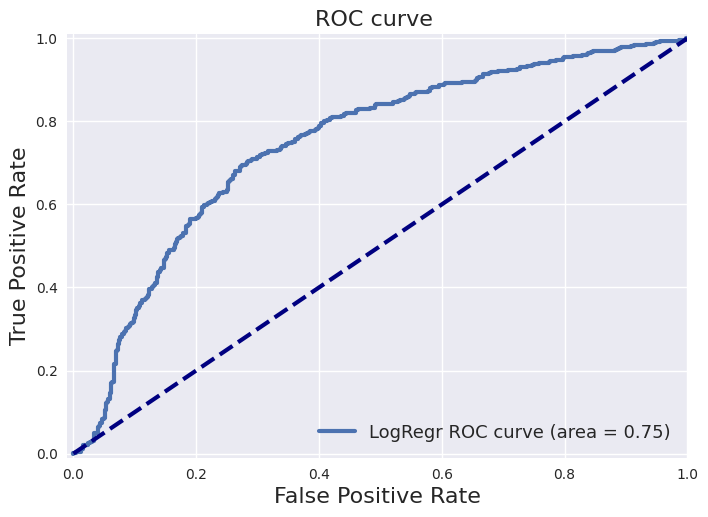


Model Name :  DecisionTree
Accuracy is  0.656188605108055
F1 score is 0.6601941747572815

Model Name :  RandomForest
Accuracy is  0.7544204322200393
F1 score is 0.750996015936255

Model Name :  KNeighbors
Accuracy is  0.7092337917485265
F1 score is 0.710371819960861

Model Name :  XGBClassifier
Accuracy is  0.7337917485265226
F1 score is 0.7335299901671583

Model Name :  SVC
Accuracy is  0.7583497053045186
F1 score is 0.7530120481927711
area under roc is 0.8217738853871954


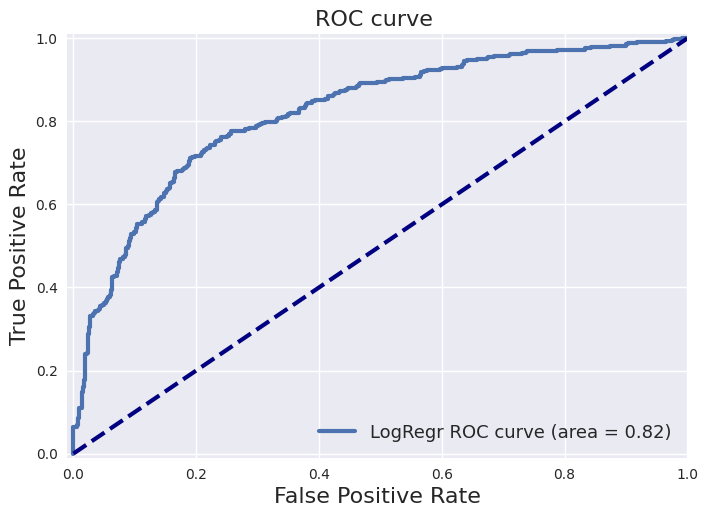


Model Name :  GaussianNB
Accuracy is  0.5176817288801572
F1 score is 0.0856610800744879

Model Name :  CatBoostClassifier
Accuracy is  0.75049115913556
F1 score is 0.7423935091277891

Model Name :  GradientBoostingClassifier
Accuracy is  0.7593320235756386
F1 score is 0.7552447552447552

Model Name :  LGBMClassifier
[LightGBM] [Info] Number of positive: 1529, number of negative: 1529
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000427 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2126
[LightGBM] [Info] Number of data points in the train set: 3058, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Accuracy is  0.7455795677799607
F1 score is 0.7407407407407408



In [166]:
for i, model in enumerate(pipelines):
    print("Model Name : ",pipeline_dict[i])
    train_and_eval(model, X_train_res.values, y_train_res, X_test_res, y_test_res, model_name=pipeline_dict[i])
    print()

In [ ]:
grid_search_evaluation(pipeline_lr,lr_params,X_train_res.values, y_train_res, X_test_res, y_test_res,cv = 10)


In [ ]:
grid_search_evaluation(pipeline_dt,dt_params,X_train_res.values, y_train_res, X_test_res, y_test_res,cv = 3)

In [ ]:
grid_search_evaluation(pipeline_kn,knn_params,X_train_res.values, y_train_res, X_test_res, y_test_res,cv = 5)

In [ ]:
grid_search_evaluation(pipeline_gnb, nb_params,X_train_res.values, y_train_res, X_test_res, y_test_res,cv = 10)

In [ ]:
grid_search_evaluation(pipeline_svm, svm_params,X_train_res.values, y_train_res, X_test_res, y_test_res,cv = 3)

In [ ]:
grid_search_evaluation(pipeline_rf,rf_params,X_train_res.values, y_train_res, X_test_res, y_test_res,cv = 3)


In [ ]:
grid_search_evaluation(pipeline_cat, cb_params,X_train_res.values, y_train_res, X_test_res, y_test_res, cv=3)


In [ ]:
grid_search_evaluation(pipeline_LightGBM, lgbm_params,X_train_res.values, y_train_res, X_test_res, y_test_res, cv=3)

In [ ]:
grid_search_evaluation(pipeline_GBM, gb_params,X_train_res.values, y_train_res, X_test_res, y_test_res, cv=3)

In [ ]:
grid_search_evaluation(pipeline_xgb, xgb_params,X_train_res.values, y_train_res, X_test_res, y_test_res,cv = 3)


### Oversampling

In [167]:
from imblearn.over_sampling import RandomOverSampler,SMOTE, ADASYN

smote = SMOTE(random_state=0)
X_train_over_sampled, y_train_over_sampled = smote.fit_resample(X_train, y_train)
X_test_over_sampled, y_test_over_sampled = smote.fit_resample(X_test, y_test)

In [168]:
print(X_test_over_sampled.shape)
print(y_test_over_sampled.shape)
print(X_train_over_sampled.shape)
print(y_train_over_sampled.shape)

(3982, 13)
(3982,)
(11942, 13)
(11942,)


Model Name :  LogisticRegression
Accuracy is  0.7091913611250628
F1 score is 0.7088989441930619
area under roc is 0.774446839002533


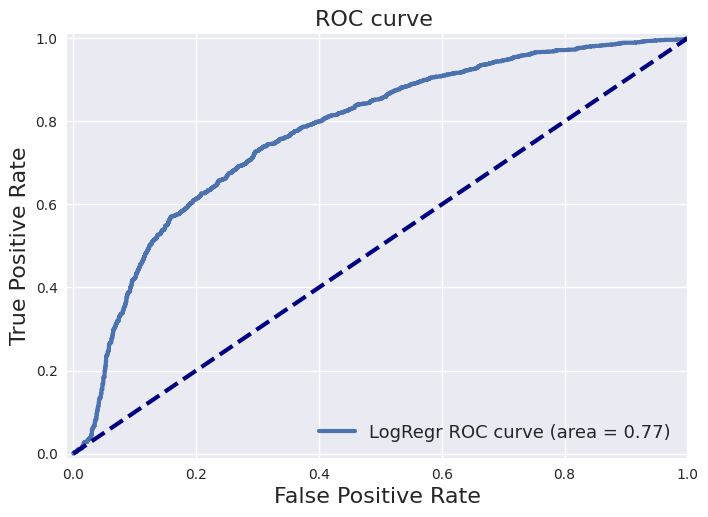


Model Name :  DecisionTree
Accuracy is  0.789552988448016
F1 score is 0.7863335033146354

Model Name :  RandomForest
Accuracy is  0.8249623304871924
F1 score is 0.8146769476203137

Model Name :  KNeighbors
Accuracy is  0.7538925163234556
F1 score is 0.7575457694210787

Model Name :  XGBClassifier
Accuracy is  0.8769462581617278
F1 score is 0.8725949037961518

Model Name :  SVC
Accuracy is  0.8211953792064289
F1 score is 0.8178096212896623
area under roc is 0.8983943567247994


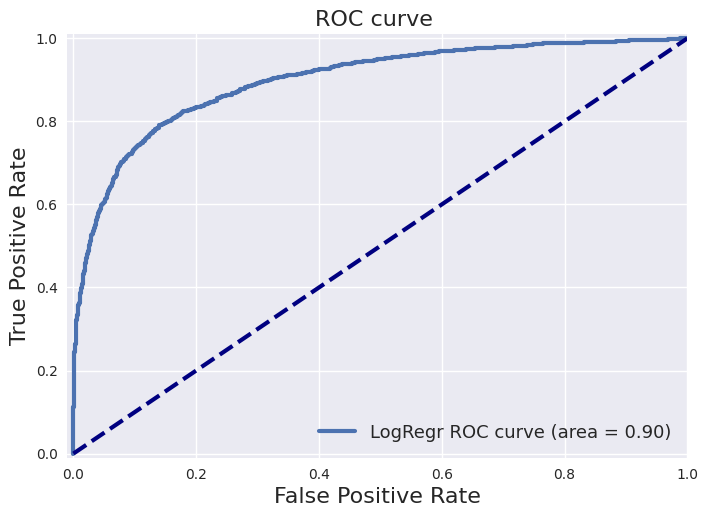


Model Name :  GaussianNB
Accuracy is  0.5007533902561527
F1 score is 0.03118908382066277

Model Name :  CatBoostClassifier
Accuracy is  0.8897538925163234
F1 score is 0.8850484420005238

Model Name :  GradientBoostingClassifier
Accuracy is  0.8628829733802109
F1 score is 0.8614916286149163

Model Name :  LGBMClassifier
[LightGBM] [Info] Number of positive: 5971, number of negative: 5971
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000701 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2383
[LightGBM] [Info] Number of data points in the train set: 11942, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Accuracy is  0.8864892014063285
F1 score is 0.8822303282959876



In [169]:
for i, model in enumerate(pipelines):
    print("Model Name : ",pipeline_dict[i])
    train_and_eval(model, X_train_over_sampled.values, y_train_over_sampled, X_test_over_sampled, y_test_over_sampled,
                   model_name=pipeline_dict[i])
    print()

We achieved better results from the inital test without resampling our data

In [ ]:
grid_search_evaluation(pipeline_lr,lr_params,X_train_over_sampled.values, y_train_over_sampled, X_test_over_sampled,
                       y_test_over_sampled,cv = 10)

In [ ]:
grid_search_evaluation(pipeline_dt,dt_params,X_train_over_sampled.values, y_train_over_sampled, X_test_over_sampled,
                       y_test_over_sampled,cv = 3)

In [ ]:
grid_search_evaluation(pipeline_rf,rf_params,X_train_over_sampled.values, y_train_over_sampled, X_test_over_sampled,
                       y_test_over_sampled,cv = 3)

In [ ]:
grid_search_evaluation(pipeline_kn,knn_params,X_train_over_sampled.values, y_train_over_sampled, X_test_over_sampled,
                       y_test_over_sampled,cv = 5)

In [ ]:
grid_search_evaluation(pipeline_gnb, nb_params,X_train_over_sampled.values, y_train_over_sampled, X_test_over_sampled,
                       y_test_over_sampled,cv = 10)

In [ ]:
grid_search_evaluation(pipeline_svm, svm_params,X_train_over_sampled.values, y_train_over_sampled, X_test_over_sampled,
                       y_test_over_sampled,cv = 3)

In [ ]:
grid_search_evaluation(pipeline_cat, cb_params, X_train, y_train, X_test, y_test, cv=3)

The oversampling method is better than undersampling because undersampling leads to losing a lot of data

we will use the default parameters for KNN and Random Forest models because they achieve better results with their default parameters and the paramters of the rest models from the grid search operation

In [181]:
lr_pipeline =Pipeline([("lr_scalar",StandardScaler()),
                     ("lr",LogisticRegression(C=0.1, penalty= 'l2'))])

dt_pipeline=Pipeline([("dt_scalar",StandardScaler()),
                     ("dt",DecisionTreeClassifier(criterion= 'gini', max_depth= 9, min_samples_split= 2))])

rf_pipeline=Pipeline([("rf_sacalat",StandardScaler()),
                     ("rf",RandomForestClassifier(max_depth=9, min_samples_leaf=3,
                                        min_samples_split=100,
                                        n_estimators=1))])


knn_pipeline=Pipeline([("knn_sclalar",StandardScaler()),
                     ("kn",KNeighborsClassifier())])

xgb_pipeline = Pipeline([("xgb_scalar",StandardScaler()),
                     ("xgb",XGBClassifier())])

svm_pipeline=Pipeline([('svc_scalar',StandardScaler()),
                       ('svm',SVC(probability=True,C= 10, gamma= 0.1, kernel= 'rbf'))])

gnb_pipeline=Pipeline([('gnb_scalar',StandardScaler()),
                       ('GaussianNB', GaussianNB(var_smoothing= 1.0))])

pipeline_cat=Pipeline([('cat_scalar',StandardScaler()),
                       ('CatBoostClassifier', CatBoostClassifier(verbose=False))])

pipeline_GBM=Pipeline([('gbm_scalar',StandardScaler()),
                       ('GradientBoostingClassifier', GradientBoostingClassifier())])

pipeline_LightGBM=Pipeline([('lgbm_scalar',StandardScaler()),
                       ('LGBMClassifier', LGBMClassifier())])


pipelines = [pipeline_lr, pipeline_dt, pipeline_rf, pipeline_kn, pipeline_xgb,pipeline_svm, pipeline_gnb,pipeline_cat,pipeline_GBM,pipeline_LightGBM]


## Ensemble learning

### Hard voting

In [182]:
h_voting_clf = VotingClassifier(
    estimators=[('cat',pipeline_cat), ('xgb',xgb_pipeline)],
    voting='hard')

train_and_eval(h_voting_clf,X_train_over_sampled.values, y_train_over_sampled, X_test_over_sampled,
                       y_test_over_sampled, model_name="Hard voting classifier")

Accuracy is  0.8839779005524862
F1 score is 0.8761394101876676


### Soft voting

In [183]:
s_voting_clf = VotingClassifier(
         estimators=[('cat',pipeline_cat), ('xgb',xgb_pipeline),]
    ,voting='soft')

train_and_eval(s_voting_clf,X_train_over_sampled.values, y_train_over_sampled, X_test_over_sampled,
                       y_test_over_sampled, model_name="Soft voting classifier")

Accuracy is  0.8849824208940231
F1 score is 0.8805425143453312


### Bagging and Pasting

We will choose catboost Classifier to build bagging and pasting classifier

In [184]:
from sklearn.ensemble import BaggingClassifier

bag_clf1 = BaggingClassifier(
    pipeline_cat, n_estimators=500,
    max_samples=100, bootstrap=True,oob_score=True, n_jobs=-1, random_state=42)
print("with bootstraping")
train_and_eval(bag_clf1,X_train_over_sampled.values, y_train_over_sampled, X_test_over_sampled,
                       y_test_over_sampled, model_name="")

bag_clf2 = BaggingClassifier(
    pipeline_cat, n_estimators=500,
    max_samples=100, bootstrap=False, n_jobs=-1, random_state=42)
print("without bootstraping")
train_and_eval(bag_clf2,X_train_over_sampled.values, y_train_over_sampled, X_test_over_sampled,
                       y_test_over_sampled, model_name="")

with bootstraping
Accuracy is  0.7606730286288297
F1 score is 0.763816604708798
without bootstraping
Accuracy is  0.7609241587142139
F1 score is 0.763888888888889


# Clustering

* K-means clustering
* KNN (k-nearest neighbors)
* Hierarchal clustering
* Anomaly detection
* Neural Networks
* Principle Component Analysis
* Independent Component Analysis
* Apriori algorithm
* Singular value decomposition

- Select Columns for Clustering
- Scalar the Data for numeric data

In [343]:
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
# features = [
#     "CreditScore",   
#     "Age",
#     "Tenure",
#     "Balance",
#     "NumOfProducts",
#     "EstimatedSalary",
#     "Satisfaction Score",
#     "Point Earned",
#     "balance_salary_rate",
#     "credit_score_rate_by_age",
#     "tenure_rate_by_age",
#     "product_utilization_rate_by_year",
#     "countries_monthly_average_salaries"
# ]
features = [
    "NumOfProducts",
    "Age",
    "countries_monthly_average_salaries",
    "Point Earned"

]

X = customer_churn_df[features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [344]:
cluster_range = range(2, 21)

best_ari = -1
best_k = None
best_labels = None

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    cluster_labels = kmeans.labels_
    ari_score = adjusted_rand_score(y_true, cluster_labels)
    
    if ari_score > best_ari:
        best_ari = ari_score
        best_k = k
        best_labels = cluster_labels

print(f"Best number of clusters: {best_k}")
print(f"Best Adjusted Rand Index (ARI): {best_ari}")

mi_score = mutual_info_score(y_true, best_labels)
homogeneity = homogeneity_score(y_true, best_labels)

print("Mutual Information Score:", mi_score)
print("Homogeneity Score:", homogeneity)

customer_churn_df['Cluster'] = best_labels

clustered_data = customer_churn_df.groupby('Cluster').mean()
print(clustered_data[features])
print(customer_churn_df['Cluster'].value_counts())

Best number of clusters: 3
Best Adjusted Rand Index (ARI): 0.06777485042219668
Mutual Information Score: 0.033984030375560234
Homogeneity Score: 0.0672118695146534
         NumOfProducts        Age  countries_monthly_average_salaries  \
Cluster                                                                 
0             1.332436  57.716689                            2.348279   
1             2.083371  35.736593                            2.529002   
2             1.000000  35.537782                            2.486500   

         Point Earned  
Cluster                
0          610.082100  
1          602.041235  
2          610.085868  
Cluster
1    4438
2    4076
0    1486
Name: count, dtype: int64


- prepare the plot of pca and T-Sne to reduce dim and also using this fuction for each algo

- **PCA Function**

In [271]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

def plot_pca(X_scaled, cluster_labels, palette='viridis', size=100, alpha=0.6):
    pca = PCA(n_components=2)  
    X_pca = pca.fit_transform(X_scaled)

    pca_df = pd.DataFrame(data = X_pca, columns=['PCA1', 'PCA2'])
    pca_df['Cluster'] = cluster_labels

    plt.figure(figsize=(6, 3))
    sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=pca_df, palette=palette, s=size, alpha=alpha)
    plt.title('Cluster Distribution after PCA')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(title='Cluster')
    plt.show()


- **t-SNE Function**

In [272]:
from sklearn.manifold import TSNE

def plot_tsne(X_scaled, cluster_labels, random_state=42, perplexity=30, n_iter=400, palette='viridis', size=100, alpha=0.6):
    tsne = TSNE(n_components=2, random_state=random_state, perplexity=perplexity, n_iter=n_iter)
    X_tsne = tsne.fit_transform(X_scaled)

    tsne_df = pd.DataFrame(data = X_tsne, columns=['t-SNE-1', 't-SNE-2'])
    tsne_df['Cluster'] = cluster_labels

    plt.figure(figsize=(6, 3))
    sns.scatterplot(x='t-SNE-1', y='t-SNE-2', hue='Cluster', data=tsne_df, palette=palette, s=size, alpha=alpha)
    plt.title('Cluster Distribution after t-SNE')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.legend(title='Cluster')
    plt.show()


# Modeling Clustering

### 1- k-Means

- Find Best parameter for K-means

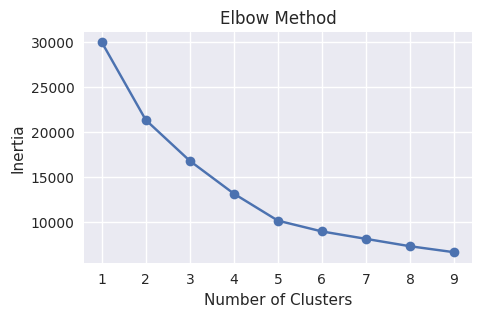

In [316]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Elbow method
inertia = []
range_values = range(1, 10)

for i in range_values:
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
plt.figure(figsize=(5, 3))  # Adjust the size as needed
plt.plot(range_values, inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()


- Apply algorithm

In [317]:
optimal_clusters = 3

kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
kmeans.fit(X_scaled)
cluster_labels = kmeans.labels_
customer_churn_df['Cluster'] = cluster_labels


#### Evaluation K-mean

In [318]:
y_true = customer_churn_df['Exited'].values
cluster_labels = cluster_labels.flatten()
ari_score = adjusted_rand_score(y_true, cluster_labels)
mi_score = mutual_info_score(y_true, cluster_labels)
homogeneity = homogeneity_score(y_true, cluster_labels)
print("Adjusted Rand Index (ARI):", ari_score)
print("Mutual Information Score:", mi_score)
print("Homogeneity Score:", homogeneity)

Adjusted Rand Index (ARI): 0.06836534104367303
Mutual Information Score: 0.03435729327622121
Homogeneity Score: 0.06795008970503812


- grouping data for visualazation

In [319]:
clustered_data = customer_churn_df.select_dtypes(include=['int64','int32', 'float64']).groupby('Cluster').mean()
print(clustered_data)
print(clustered_data[features])  
print(customer_churn_df['Cluster'].value_counts())

         CreditScore        Age    Tenure       Balance  NumOfProducts  \
Cluster                                                                  
0         649.503704  57.724579  4.969697  83456.437764       1.329966   
1         652.115714  35.749212  5.054705  53266.756461       2.083296   
2         649.171863  35.526393  4.982814  99267.161945       1.000000   

         EstimatedSalary    Exited  Satisfaction Score  Point Earned  \
Cluster                                                                
0           98153.044727  0.448485            3.011448    612.592593   
1          100940.719674  0.116614            2.994147    601.226925   
2           99869.003339  0.209673            3.036091    610.066536   

         balance_salary_rate  ...  Cluster_2_3  Cluster_2_4  Cluster_2_5  \
Cluster                       ...                                          
0                   4.385485  ...     0.329966     2.057912     0.319192   
1                   1.782408  ...     1.

- Visualizing the distribution of clusters

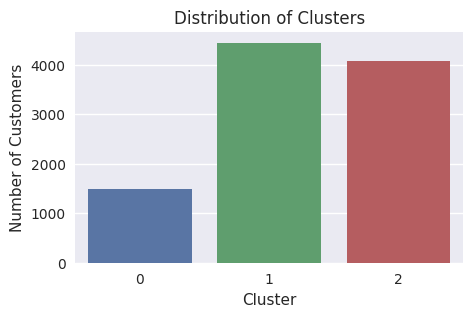

In [320]:
plt.figure(figsize=(5, 3))  # Adjust the size as needed
sns.countplot(x='Cluster', data=customer_churn_df)
plt.title('Distribution of Clusters')
plt.xlabel('Cluster')
plt.ylabel('Number of Customers')
plt.show()

# # Further visual analysis using pairplot to visualize the relationship between features per cluster
# sns.pairplot(customer_churn_df, vars=features, hue='Cluster', palette='bright')
# plt.show()

- Plot with PCA

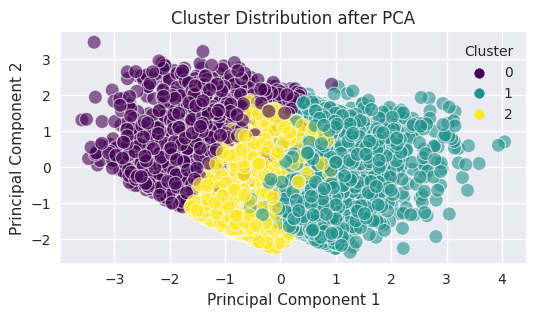

In [321]:
plot_pca(X_scaled, customer_churn_df['Cluster'])

- Plot with T-SNE

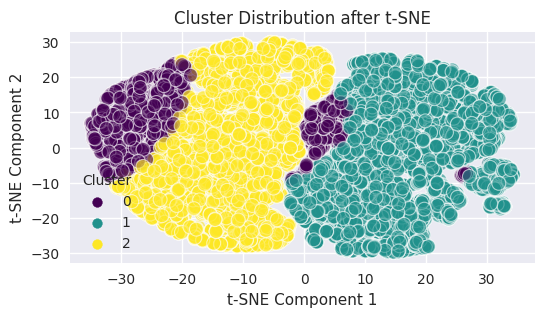

In [322]:
plot_tsne(X_scaled, customer_churn_df['Cluster'])

## 2-DBSCAN

- Find Best Paramter for DBSAN

In [323]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN

def dbscan_grid_search(data, eps_values, min_samples_values):
    best_score = -1
    best_params = {'eps': None, 'min_samples': None}
    best_labels = None
    
    for eps in eps_values:
        for min_samples in min_samples_values:
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            labels = dbscan.fit_predict(data)
            
            if len(set(labels)) > 1:
                score = silhouette_score(data, labels)
                print(f"eps :  {eps} and sample : {min_samples} and score : {score} ")     
                if score > best_score:
                    best_score = score
                    best_params['eps'] = eps
                    best_params['min_samples'] = min_samples
                    best_labels = labels
    
    return best_params, best_score, best_labels

In [ ]:
eps_values = [0.1, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.5, 1.7, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0, 8.5, 9.0, 9.5, 10.0]
min_samples_values = [2, 3, 5, 7, 10, 12, 15, 17, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]

best_params, best_score, best_labels = dbscan_grid_search(X_scaled, eps_values, min_samples_values)

print(f"Best params: {best_params}")
print(f"Best silhouette score: {best_score}")

- Apply algorithm

In [324]:
dbscan = DBSCAN(eps=1.7, min_samples=2)

customer_churn_df['DBSCAN_Cluster'] = dbscan.fit_predict(X_scaled)

unique_clusters = np.unique(customer_churn_df['DBSCAN_Cluster'])
print(f"Unique clusters found by DBSCAN: {unique_clusters}")

Unique clusters found by DBSCAN: [0 1 2 3]


# Evaluation

In [325]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import adjusted_rand_score, silhouette_score, calinski_harabasz_score

ari_dbscan = adjusted_rand_score(y_true, customer_churn_df['DBSCAN_Cluster'])
silhouette_dbscan = silhouette_score(X_scaled, customer_churn_df['DBSCAN_Cluster'])
calinski_dbscan = calinski_harabasz_score(X_scaled, customer_churn_df['DBSCAN_Cluster'])

print("Adjusted Rand Index (ARI) for DBSCAN:", ari_dbscan)
print("Silhouette Coefficient for DBSCAN:", silhouette_dbscan)
print("Calinski-Harabasz Index for DBSCAN:", calinski_dbscan)

Adjusted Rand Index (ARI) for DBSCAN: 0.07487232685098485
Silhouette Coefficient for DBSCAN: 0.3146246064522148
Calinski-Harabasz Index for DBSCAN: 1705.0548438635576


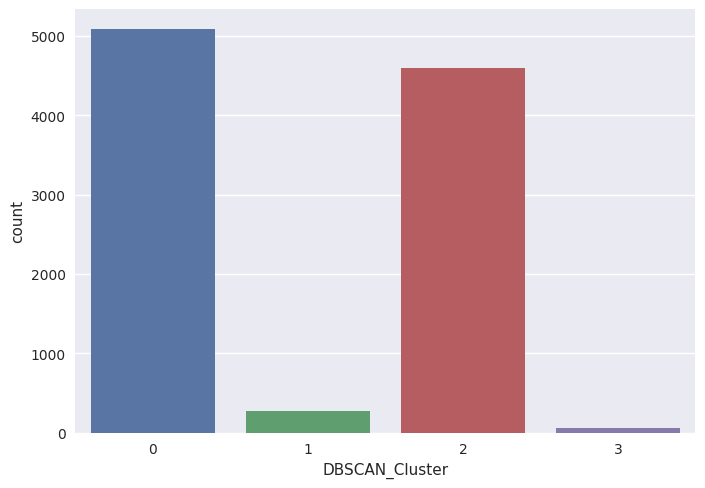

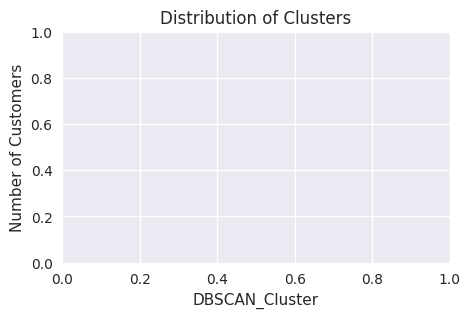

In [326]:
sns.countplot(x='DBSCAN_Cluster', data=customer_churn_df)
plt.figure(figsize=(5, 3))  # Adjust the size as needed
plt.title('Distribution of Clusters')
plt.xlabel('DBSCAN_Cluster')
plt.ylabel('Number of Customers')
plt.show()

-  Plot With Pca

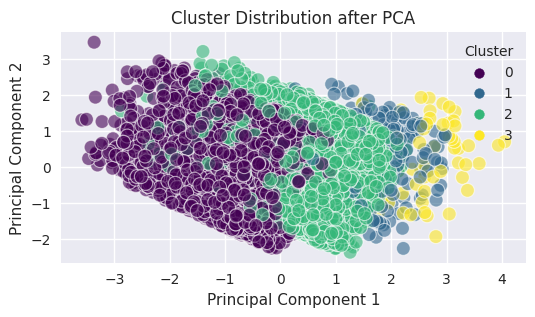

In [327]:
plot_pca(X_scaled, customer_churn_df['DBSCAN_Cluster'])

- Plot with T-SNE

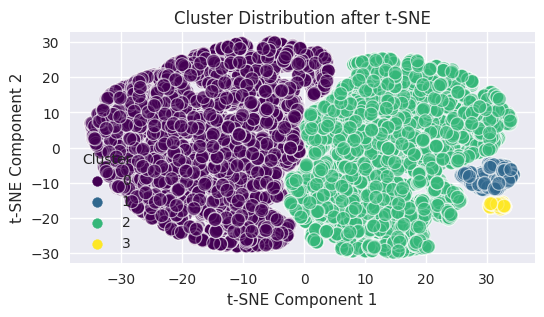

In [328]:
plot_tsne(X_scaled,customer_churn_df['DBSCAN_Cluster'])

### 3- Hierarchical Clustering

- we will use all type of Distance Measures and Linkage Criteria to see what is best result we can get from this options


- **single + euclidean**

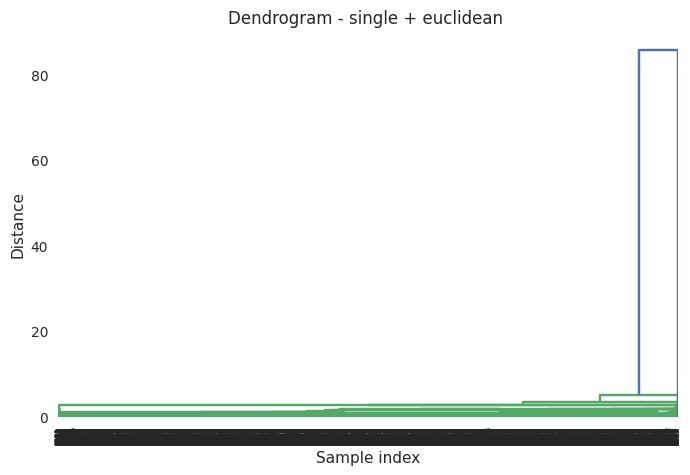

In [127]:
linked = linkage(X_scaled, method='single', metric='euclidean')
plt.figure(figsize=(8, 5))
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.title(f'Dendrogram - single + euclidean ')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.show()

#### Evalaution

- **complete + cityblock**

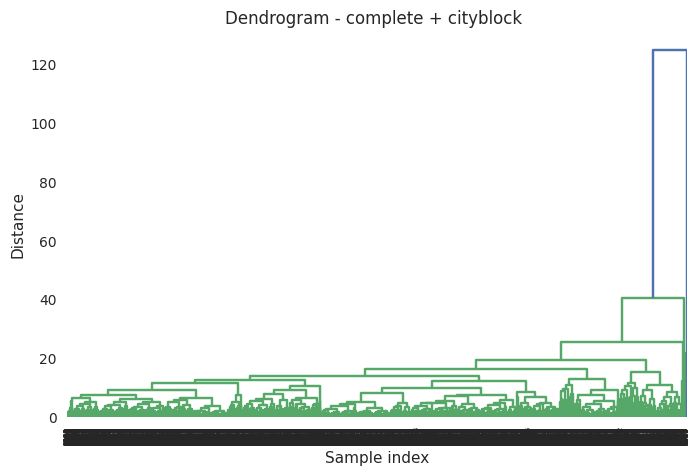

In [128]:
linked = linkage(X_scaled, method='complete', metric='cityblock')
plt.figure(figsize=(8, 5))
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.title(f'Dendrogram - complete + cityblock ')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.show()

- **average + chebyshev**

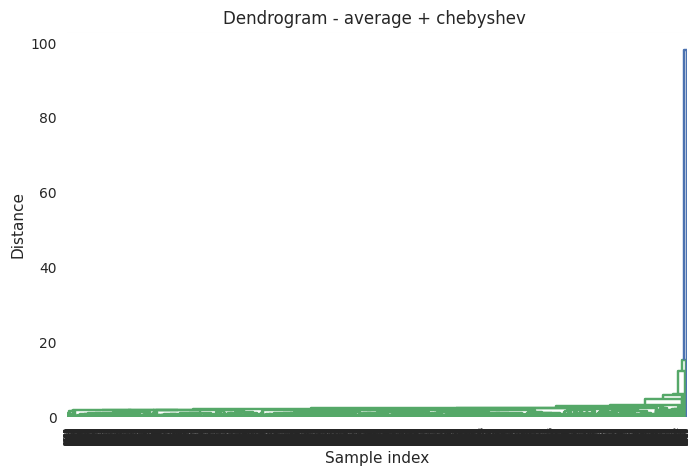

In [129]:
linked = linkage(X_scaled, method='average', metric='chebyshev')
plt.figure(figsize=(8, 5))
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.title(f'Dendrogram - average + chebyshev ')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.show()

In [214]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, MiniBatchKMeans, BisectingKMeans, SpectralClustering
minibatch_kmeans = MiniBatchKMeans(n_clusters=2, batch_size=100, random_state=42)
minibatch_kmeans_labels = minibatch_kmeans.fit_predict(X_scaled)

In [215]:
def plot_pca(X_pca, labels, title):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels, palette="viridis", s=100, alpha=0.6)
    plt.title(title)
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend(title='Cluster')
    plt.show()

def plot_tsne(X_tsne, labels, title):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=labels, palette="viridis", s=100, alpha=0.6)
    plt.title(title)
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.legend(title='Cluster')
    plt.show()

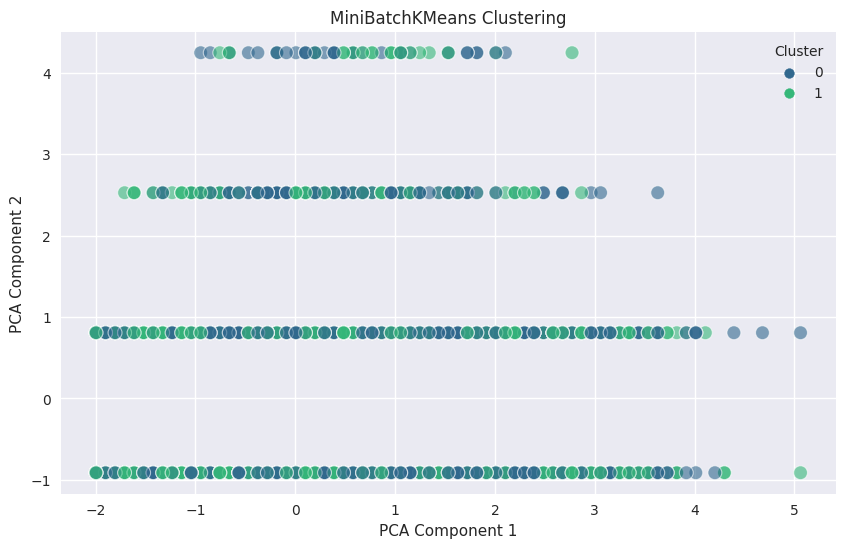

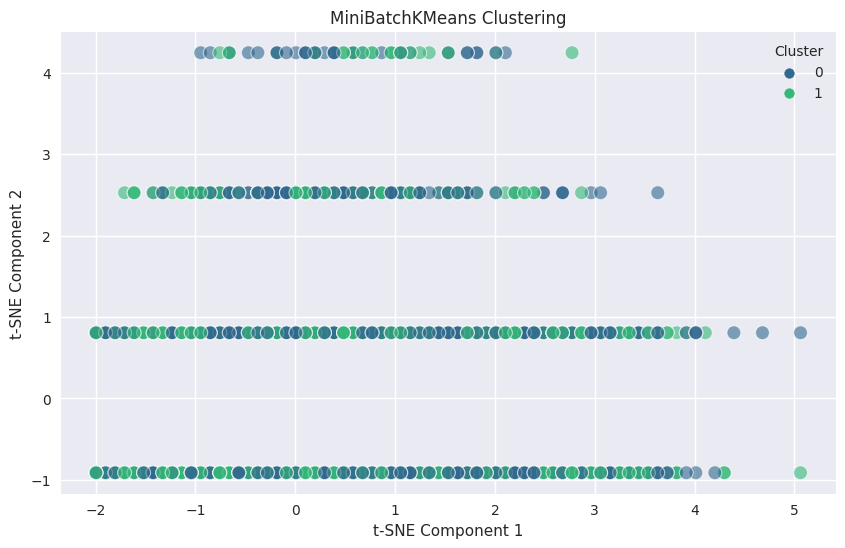

In [216]:
# Plot MiniBatchKMeans results
plot_pca(X_scaled, minibatch_kmeans_labels, 'MiniBatchKMeans Clustering')
plot_tsne(X_scaled, minibatch_kmeans_labels, 'MiniBatchKMeans Clustering')

In [ ]:
# Spectral Clustering
spectral_clustering = SpectralClustering(n_clusters=2, affinity='rbf', gamma=8, assign_labels='kmeans')
spectral_clustering_labels = spectral_clustering.fit_predict(X_scaled)
# Plot Spectral Clustering results
plot_pca(X_scaled, spectral_clustering_labels, 'Spectral Clustering')
plot_tsne(X_scaled, spectral_clustering_labels, 'Spectral Clustering')